In [1]:
import os
import pickle
import sys

# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from time import perf_counter


Initialize test slab and parameters

In [2]:
# Load prepared pristine slab
adsorbates = ["Sr", "Ti", "O"]
chem_pot = [-2, 0, 0] # in eV, 1 entry for each chempot

element = []
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)

surface_name = 'SrTiO3(001)'
alpha = 1 # no annealing
temp = 1.0 # in terms of kbT
num_sweeps = 10 # can adjust

Obtain adsorption sites

In [3]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)
sites = site_finder.find_adsorption_sites(
    distance=1.55, put_inside=False, symm_reduce=False, no_obtuse_hollow=False
)
ads_positions = sites['all']
print("adsorption coordinates are")
print(ads_positions)

adsorption coordinates are
[array([-1.20427451e-05, -2.92606645e-02,  1.88703535e+01]), array([ 1.96776177,  1.95126006, 18.82924596]), array([ 1.96778444,  0.14564931, 18.78214629]), array([-1.20427451e-05,  3.95573460e+00,  1.88703535e+01]), array([ 1.96776177,  5.93625532, 18.82924596]), array([ 1.96778444,  4.13064457, 18.78214629]), array([ 3.93552559, -0.02926066, 18.8703535 ]), array([ 5.9032994 ,  1.95126006, 18.82924596]), array([ 5.90332207,  0.14564931, 18.78214629]), array([ 3.93552559,  3.9557346 , 18.8703535 ]), array([ 5.9032994 ,  5.93625532, 18.82924596]), array([ 5.90332207,  4.13064457, 18.78214629]), array([ 9.83884836, 30.93591913, 18.80569613]), array([ 8.85495012, 30.84846415, 18.84979973]), array([29.51653651, 30.93591913, 18.80569613]), array([30.50040709, 30.84846415, 18.84979973]), array([14.7582679 , 15.99817536, 18.8262499 ]), array([15.74214348, 13.90624584, 18.82924596]), array([30.50040709, 28.85596652, 18.84979973]), array([ 8.85495012, 28.85596652, 18.

Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039).

In [4]:
import torch
from nff.io import NeuralFF, AtomsBatch, EnsembleNFF 

if torch.cuda.is_available():
    DEVICE = 0
else:
    DEVICE = "cpu"

nnids = ['model01', 'model02', 'model03']
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_calc = EnsembleNFF(models, device=DEVICE)

# set attributes
CUTOFF = 5
relax = True
relax_steps = 5
optimizer = "BFGS"
offset = True
offset_data = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

slab_batch = AtomsBatch(
    positions=slab.positions,
    numbers=slab.numbers,
    cell=slab.cell,
    pbc=True,
    cutoff=CUTOFF,
    props={"energy": 0, "energy_grad": []},
    calculator=nff_calc,
    requires_large_offsets=True,
    directed=True,
    device=DEVICE,
    )

# fix bulk atoms
from ase.constraints import FixAtoms

num_bulk_atoms = len(slab_batch)
bulk_indices = list(range(num_bulk_atoms))
print(f"bulk indices {bulk_indices}")
surf_indices = slab.get_surface_atoms()

fix_indices = list(set(bulk_indices) - set(surf_indices))
print(f"fix indices {fix_indices}")

c = FixAtoms(indices=fix_indices)
slab_batch.set_constraint(c)

bulk indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
fix indices [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58]


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2023-05-20 14:24:02,828|INFO|Running with num_sweeps = 10, temp = 1.0, pot = [-2, 0, 0], alpha = 1
2023-05-20 14:24:02,829|INFO|using slab calc <nff.io.ase.EnsembleNFF object at 0x7f8af811b610>
2023-05-20 14:24:02,829|INFO|there are 60 atoms in pristine slab
2023-05-20 14:24:02,830|INFO|adsorbate(s) is(are) ['Sr', 'Ti', 'O']
2023-05-20 14:24:02,831|INFO|In pristine slab, there are a total of 72 sites
2023-05-20 14:24:03,332|INFO|running for 72 iterations per run over a total of 10 runs
2023-05-20 14:24:03,333|INFO|In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:24:03       11.338886        2.5564
BFGS:    1 14:24:03       11.092899        3.2768
BFGS:    2 14:24:03       11.055232        4.2276
BFGS:    3 14:24:03        9.785459        3.3325
BFGS:    4 14:24:03        9.704774        3.1371
BFGS:    5 14:24:03        9.387753        2.0388
      Step     Time          Energy         fmax
BFGS:    0 14:24:04        9.676270        8.1594
BFGS:    1 14:24:04        8.197362        2.9782
BFGS:    2 14:24:04        7.356123        2.3895
BFGS:    3 14:24:04        6.785808        2.8066
BFGS:    4 14:24:04        6.361583        3.1990
BFGS:    5 14:24:04        6.119650        3.9445
      Step     Time          Energy         fmax
BFGS:    0 14:24:05        7.811028        7.1441
BFGS:    1 14:24:05        6.798577        4.4463
BFGS:    2 14:24:05        5.541143        2.7943
BFGS:    3 14:24:05        4.912394        2.4125
BFGS:    4 14:24:05        4.305137        2.7666
BFG

2023-05-20 14:24:08,767|INFO|encountered energy out of bounds
2023-05-20 14:24:08,767|INFO|energy 34769.945
2023-05-20 14:24:08,768|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:08,768|INFO|max_force 624620.938, energy 231.404
2023-05-20 14:24:08,769|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:08       -0.345851       22.1274
BFGS:    1 14:24:09       -5.551549        7.5732
BFGS:    2 14:24:09       -7.861288        4.7033
BFGS:    3 14:24:09       -9.847601        2.9800
BFGS:    4 14:24:09      -10.821800        3.4144
BFGS:    5 14:24:09      -11.918628        2.9267
      Step     Time          Energy         fmax
BFGS:    0 14:24:09       -2.382491       21.7025
BFGS:    1 14:24:09       -7.699932        7.5069
BFGS:    2 14:24:09      -10.472676        4.7804
BFGS:    3 14:24:10      -12.731641        3.6798
BFGS:    4 14:24:10      -14.081981        4.5317
BFGS:    5 14:24:10      -15.225407        4.7454
      Step     Time          Energy         fmax
BFGS:    0 14:24:10       12.318257       22.2156
BFGS:    1 14:24:10        7.340724        7.4180
BFGS:    2 14:24:10        5.920189        4.4193
BFGS:    3 14:24:10        4.542702        2.9268
BFGS:    4 14:24:10        3.507718        4.3146
BFG

2023-05-20 14:24:24,946|INFO|encountered energy out of bounds
2023-05-20 14:24:24,947|INFO|energy 229299.297
2023-05-20 14:24:24,948|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:24,949|INFO|max_force 19610270.000, energy 209.372
2023-05-20 14:24:24,949|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:25       47.253948       35.5565
BFGS:    1 14:24:25       38.081814       14.1295
BFGS:    2 14:24:25       31.583204        7.3992
BFGS:    3 14:24:25       27.607971        4.3880
BFGS:    4 14:24:25       25.385904        2.5076
BFGS:    5 14:24:25       24.166571        2.1036


2023-05-20 14:24:25,891|INFO|encountered energy out of bounds
2023-05-20 14:24:25,891|INFO|energy 414.028
2023-05-20 14:24:25,893|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:25,893|INFO|max_force 4497.138, energy 216.257
2023-05-20 14:24:25,893|INFO|saving this slab
2023-05-20 14:24:25,995|INFO|encountered energy out of bounds
2023-05-20 14:24:25,996|INFO|energy 582.462
2023-05-20 14:24:25,997|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:25,998|INFO|max_force 8275.968, energy 190.451
2023-05-20 14:24:25,999|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:26       49.875446       36.8662
BFGS:    1 14:24:26       40.728077       15.1306
BFGS:    2 14:24:26       33.993298        7.8284
BFGS:    3 14:24:26       29.237257        4.5115
BFGS:    4 14:24:26       26.067085        4.1783
BFGS:    5 14:24:26       24.150034        2.9605
      Step     Time          Energy         fmax
BFGS:    0 14:24:27       71.322746       76.0944
BFGS:    1 14:24:27       61.688004       22.7343
BFGS:    2 14:24:27       49.456867       12.6853
BFGS:    3 14:24:27       40.080273        5.6222
BFGS:    4 14:24:27       35.244549        5.2274
BFGS:    5 14:24:27       32.426163        3.2418


2023-05-20 14:24:27,705|INFO|encountered energy out of bounds
2023-05-20 14:24:27,705|INFO|energy 34816.016
2023-05-20 14:24:27,706|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:27,707|INFO|max_force 624501.062, energy 212.585
2023-05-20 14:24:27,707|INFO|saving this slab
2023-05-20 14:24:27,836|INFO|encountered energy out of bounds
2023-05-20 14:24:27,837|INFO|energy 583.734
2023-05-20 14:24:27,838|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:27,839|INFO|max_force 8255.633, energy 205.700
2023-05-20 14:24:27,840|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:28       33.503498       36.7128
BFGS:    1 14:24:28       23.480743       14.7017
BFGS:    2 14:24:28       15.045616        7.4512
BFGS:    3 14:24:28        9.949249        4.3735
BFGS:    4 14:24:28        7.385256        2.6055
BFGS:    5 14:24:28        6.245975        2.5646
      Step     Time          Energy         fmax
BFGS:    0 14:24:29       56.781342       37.3096
BFGS:    1 14:24:29       47.584183       15.5405
BFGS:    2 14:24:29       40.794689        7.9258
BFGS:    3 14:24:29       35.797504        4.6473
BFGS:    4 14:24:29       32.254871        4.7576
BFGS:    5 14:24:29       30.146820        3.1092
      Step     Time          Energy         fmax
BFGS:    0 14:24:30       46.536976       36.4935
BFGS:    1 14:24:30       29.604849       17.2217
BFGS:    2 14:24:30       19.514847        9.4335
BFGS:    3 14:24:30       12.424914        5.6436
BFGS:    4 14:24:30        8.423049        3.0797
BFG

2023-05-20 14:24:33,049|INFO|encountered energy out of bounds
2023-05-20 14:24:33,050|INFO|energy 946.838
2023-05-20 14:24:33,051|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:33,052|INFO|max_force 10114.196, energy 217.277
2023-05-20 14:24:33,052|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:33       42.628651       34.8021
BFGS:    1 14:24:33       23.382614       12.6165
BFGS:    2 14:24:33        8.831317        7.2090
BFGS:    3 14:24:33        0.915918        4.6734
BFGS:    4 14:24:33       -3.211051        3.9884
BFGS:    5 14:24:33       -5.910070        5.2241


2023-05-20 14:24:33,990|INFO|encountered energy out of bounds
2023-05-20 14:24:33,991|INFO|energy 280.855
2023-05-20 14:24:33,992|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:33,992|INFO|max_force 3629.834, energy 217.277
2023-05-20 14:24:33,993|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:34       27.649496       35.1778
BFGS:    1 14:24:34        5.604431       12.7826
BFGS:    2 14:24:34      -10.217944        6.9233
BFGS:    3 14:24:34      -18.993807        4.1993
BFGS:    4 14:24:34      -22.823195        8.1495
BFGS:    5 14:24:34      -25.904205        6.1998


2023-05-20 14:24:34,827|INFO|encountered energy out of bounds
2023-05-20 14:24:34,828|INFO|energy 1670.935
2023-05-20 14:24:34,829|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:34,829|INFO|max_force 29574.273, energy 243.083
2023-05-20 14:24:34,830|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:35       82.250603      137.4711
BFGS:    1 14:24:35       40.148914       54.8882
BFGS:    2 14:24:35       17.191483       38.2787
BFGS:    3 14:24:35       -2.900439       19.1489
BFGS:    4 14:24:35      -13.520654       10.9358
BFGS:    5 14:24:35      -18.243494        6.4723
      Step     Time          Energy         fmax
BFGS:    0 14:24:35      127.129417     1180.5220
BFGS:    1 14:24:35      198.699783     2300.1888
BFGS:    2 14:24:36       67.572800      382.4566
BFGS:    3 14:24:36       42.320889      285.2404
BFGS:    4 14:24:36       28.914297      103.7507
BFGS:    5 14:24:36       14.465766       31.5126


2023-05-20 14:24:36,606|INFO|encountered energy out of bounds
2023-05-20 14:24:36,607|INFO|energy 700.237
2023-05-20 14:24:36,607|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:36,609|INFO|max_force 10099.101, energy 217.277
2023-05-20 14:24:36,610|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:36      123.097984     1015.2272
BFGS:    1 14:24:36       58.547962       47.0825
BFGS:    2 14:24:37       34.748104       41.4532
BFGS:    3 14:24:37       14.123711       55.6494
BFGS:    4 14:24:37       -0.972386       36.5583
BFGS:    5 14:24:37       -9.504208       21.5429


2023-05-20 14:24:37,442|INFO|encountered energy out of bounds
2023-05-20 14:24:37,443|INFO|energy 391.721
2023-05-20 14:24:37,444|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:37,444|INFO|max_force 5164.270, energy 217.277
2023-05-20 14:24:37,445|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:37       32.225437       35.5838
BFGS:    1 14:24:37        8.517743       13.7563
BFGS:    2 14:24:37       -7.812479        8.6549
BFGS:    3 14:24:37      -17.408119        5.6442
BFGS:    4 14:24:38      -22.502991        3.2916
BFGS:    5 14:24:38      -25.146322        2.3620
      Step     Time          Energy         fmax
BFGS:    0 14:24:38       50.700043       44.3760
BFGS:    1 14:24:38       29.511282       16.6741
BFGS:    2 14:24:38       15.440892       11.7381
BFGS:    3 14:24:38        4.748164        7.3182
BFGS:    4 14:24:38       -0.723034        4.1422
BFGS:    5 14:24:38       -3.572659        3.3607
      Step     Time          Energy         fmax
BFGS:    0 14:24:39       79.081322      436.8691
BFGS:    1 14:24:39       67.626778       49.5718
BFGS:    2 14:24:39       33.683353       27.9701
BFGS:    3 14:24:39       10.970799       38.8972
BFGS:    4 14:24:39       -5.842222       44.1001
BFG

2023-05-20 14:24:40,838|INFO|encountered energy out of bounds
2023-05-20 14:24:40,839|INFO|energy 375.856
2023-05-20 14:24:40,840|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:40,841|INFO|max_force 5165.078, energy 220.949
2023-05-20 14:24:40,841|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:41       24.917147       35.9588
BFGS:    1 14:24:41       15.834193       14.5302
BFGS:    2 14:24:41        8.559035        8.5264
BFGS:    3 14:24:41        3.951151        5.1670
BFGS:    4 14:24:41        1.325972        3.1330
BFGS:    5 14:24:41       -0.375450        4.6649
      Step     Time          Energy         fmax
BFGS:    0 14:24:41       27.049271       36.3371
BFGS:    1 14:24:41        9.452449       14.4365
BFGS:    2 14:24:41        0.369716        8.1889
BFGS:    3 14:24:42       -5.748596        5.1581
BFGS:    4 14:24:42       -9.437032        4.4914
BFGS:    5 14:24:42      -11.882443        3.3907


2023-05-20 14:24:42,475|INFO|encountered energy out of bounds
2023-05-20 14:24:42,476|INFO|energy 564.326
2023-05-20 14:24:42,477|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:42,477|INFO|max_force 8255.374, energy 205.700
2023-05-20 14:24:42,478|INFO|saving this slab
2023-05-20 14:24:42,569|INFO|encountered energy out of bounds
2023-05-20 14:24:42,569|INFO|energy 379.544
2023-05-20 14:24:42,570|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:42,571|INFO|max_force 5174.811, energy 224.621
2023-05-20 14:24:42,571|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:42       25.241255       35.9089
BFGS:    1 14:24:42       17.914366       15.5836
BFGS:    2 14:24:42        1.733006       21.0668
BFGS:    3 14:24:43       70.564384     1239.8102
BFGS:    4 14:24:43       -6.615166       33.2545
BFGS:    5 14:24:43       -8.591736       16.8152


2023-05-20 14:24:43,434|INFO|encountered energy out of bounds
2023-05-20 14:24:43,437|INFO|energy 310377.500
2023-05-20 14:24:43,437|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:43,438|INFO|max_force 6713059.500, energy 205.700
2023-05-20 14:24:43,439|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:43       26.009369       35.8828
BFGS:    1 14:24:43        7.736910       18.0069
BFGS:    2 14:24:43       -3.184757       10.3641
BFGS:    3 14:24:43      -11.272811        6.8408
BFGS:    4 14:24:44      -15.450849        4.5374
BFGS:    5 14:24:44      -17.831285        3.5179
      Step     Time          Energy         fmax
BFGS:    0 14:24:44       17.586382       33.4865
BFGS:    1 14:24:44       -5.980148       17.3622
BFGS:    2 14:24:44      -17.010607       10.0147
BFGS:    3 14:24:44      -25.123817        5.4261
BFGS:    4 14:24:44      -29.130714        4.8532
BFGS:    5 14:24:44      -31.389610        3.5823
      Step     Time          Energy         fmax
BFGS:    0 14:24:45       48.263367       82.2285
BFGS:    1 14:24:45       40.447323       48.7675
BFGS:    2 14:24:45       23.028116       27.3130
BFGS:    3 14:24:45        7.460814       16.1725
BFGS:    4 14:24:45       -2.446992       10.8833
BFG

2023-05-20 14:24:51,320|INFO|current energy is 7.636173871338201, calculated energy is 7.636170414268804
2023-05-20 14:24:51,321|INFO|optim structure has Free Energy = 11.636+/-0.156
2023-05-20 14:24:51,322|INFO|average force error = 0.052
2023-05-20 14:24:51,325|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:24:51       96.419434      598.7656
BFGS:    1 14:24:51       54.400005       47.2630
BFGS:    2 14:24:51       35.314281       30.4567
BFGS:    3 14:24:51       28.392229      144.1726
BFGS:    4 14:24:51       16.544853       41.9510
BFGS:    5 14:24:51       11.812035        9.6932
      Step     Time          Energy         fmax
BFGS:    0 14:24:52       93.323860       50.5683
BFGS:    1 14:24:52       45.995480      110.5839
BFGS:    2 14:24:52       18.368876       48.0451
BFGS:    3 14:24:52        3.259338       24.5736
BFGS:    4 14:24:52       -6.697040       12.9772
BFGS:    5 14:24:52      -12.210907        7.7233
      Step     Time          Energy         fmax
BFGS:    0 14:24:53       45.658672       39.3312
BFGS:    1 14:24:53       31.868948       16.5434
BFGS:    2 14:24:53       22.916725        8.7964
BFGS:    3 14:24:53       15.733001        4.7428
BFGS:    4 14:24:53       12.244199        7.9154
BFG

2023-05-20 14:24:53,788|INFO|encountered energy out of bounds
2023-05-20 14:24:53,789|INFO|energy 397.251
2023-05-20 14:24:53,790|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:53,791|INFO|max_force 5173.631, energy 220.949
2023-05-20 14:24:53,792|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:54       38.175449       36.0114
BFGS:    1 14:24:54       27.924433       14.2949
BFGS:    2 14:24:54       18.571562        7.9908
BFGS:    3 14:24:54       12.734825        5.1010
BFGS:    4 14:24:54        9.782771        5.7043
BFGS:    5 14:24:54        7.953403        2.7471
      Step     Time          Energy         fmax
BFGS:    0 14:24:55       37.210678       39.0444
BFGS:    1 14:24:55       22.325949       17.0421
BFGS:    2 14:24:55       11.274265       10.0388
BFGS:    3 14:24:55        2.309393        6.7611
BFGS:    4 14:24:55       -2.572759        7.2866
BFGS:    5 14:24:55       -6.023827        3.8490
      Step     Time          Energy         fmax
BFGS:    0 14:24:55       33.163605       49.6312
BFGS:    1 14:24:55       16.893900       17.4173
BFGS:    2 14:24:56        8.034865        7.5954
BFGS:    3 14:24:56        0.816198        4.2233
BFGS:    4 14:24:56       -2.998204        3.3268
BFG

2023-05-20 14:24:58,260|INFO|encountered energy out of bounds
2023-05-20 14:24:58,261|INFO|energy 1657.649
2023-05-20 14:24:58,262|INFO|encountered energy or forces out of bounds
2023-05-20 14:24:58,263|INFO|max_force 29807.018, energy 217.277
2023-05-20 14:24:58,264|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:24:58       62.484661      105.2367
BFGS:    1 14:24:58       38.804031       29.6590
BFGS:    2 14:24:58       24.521540       17.4258
BFGS:    3 14:24:58       13.759580       12.7892
BFGS:    4 14:24:58        6.639254        7.9427
BFGS:    5 14:24:58        2.489839        5.4957
      Step     Time          Energy         fmax
BFGS:    0 14:24:59       52.319000       38.9711
BFGS:    1 14:24:59       38.172955       16.6160
BFGS:    2 14:24:59       28.878168        8.7477
BFGS:    3 14:24:59       21.236025        4.8715
BFGS:    4 14:24:59       17.839685        9.5810
BFGS:    5 14:24:59       15.352754        2.6671
      Step     Time          Energy         fmax
BFGS:    0 14:24:59       43.160488       35.3738
BFGS:    1 14:25:00       32.604351       13.7528
BFGS:    2 14:25:00       22.667780        7.4123
BFGS:    3 14:25:00       16.670599        4.4081
BFGS:    4 14:25:00       13.643027        3.8469
BFG

2023-05-20 14:25:03,078|INFO|encountered energy out of bounds
2023-05-20 14:25:03,079|INFO|energy 1670.662
2023-05-20 14:25:03,080|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:03,080|INFO|max_force 29615.584, energy 239.411
2023-05-20 14:25:03,081|INFO|saving this slab
2023-05-20 14:25:03,189|INFO|encountered energy out of bounds
2023-05-20 14:25:03,190|INFO|energy 310026.062
2023-05-20 14:25:03,191|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:03,191|INFO|max_force 6704333.500, energy 232.526
2023-05-20 14:25:03,192|INFO|saving this slab
2023-05-20 14:25:03,273|INFO|encountered energy out of bounds
2023-05-20 14:25:03,275|INFO|energy 313722.562
2023-05-20 14:25:03,276|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:03,276|INFO|max_force 6809561.500, energy 239.411
2023-05-20 14:25:03,277|INFO|saving this slab
2023-05-20 14:25:03,379|INFO|encountered energy out of bounds
2023-05-20 14:25:03,380|INFO|energy 389651.344
2023-05-20 14

      Step     Time          Energy         fmax
BFGS:    0 14:25:03       78.883362      491.3400
BFGS:    1 14:25:03       45.507435       58.0101
BFGS:    2 14:25:03       27.515348       50.0461
BFGS:    3 14:25:03       12.327946       29.9455
BFGS:    4 14:25:03       -1.806781       16.9763
BFGS:    5 14:25:04      -12.079972        8.7432
      Step     Time          Energy         fmax
BFGS:    0 14:25:04       78.883347      491.3400
BFGS:    1 14:25:04       45.507435       58.0101
BFGS:    2 14:25:04       27.515348       50.0461
BFGS:    3 14:25:04       12.327947       29.9455
BFGS:    4 14:25:04       -1.806790       16.9763
BFGS:    5 14:25:04      -12.079986        8.7432


2023-05-20 14:25:04,972|INFO|encountered energy out of bounds
2023-05-20 14:25:04,974|INFO|energy 1563.696
2023-05-20 14:25:04,975|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:04,976|INFO|max_force 28046.602, energy 239.411
2023-05-20 14:25:04,977|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:25:05       60.718735       73.0432
BFGS:    1 14:25:05       31.373571       23.4485
BFGS:    2 14:25:05       13.018367       23.3705
BFGS:    3 14:25:05       -1.533123       14.8030
BFGS:    4 14:25:05      -11.615314       10.3608
BFGS:    5 14:25:05      -18.654999        7.1538
      Step     Time          Energy         fmax
BFGS:    0 14:25:06       48.050037       89.4878
BFGS:    1 14:25:06       49.723553      241.0519
BFGS:    2 14:25:06       25.075180       26.6294
BFGS:    3 14:25:06        9.507777       12.7733
BFGS:    4 14:25:06       -3.185629       36.1261
BFGS:    5 14:25:06      -12.210711        9.9600


2023-05-20 14:25:06,731|INFO|encountered energy out of bounds
2023-05-20 14:25:06,732|INFO|energy 395.771
2023-05-20 14:25:06,733|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:06,733|INFO|max_force 5165.447, energy 213.606
2023-05-20 14:25:06,734|INFO|saving this slab
2023-05-20 14:25:06,840|INFO|encountered energy out of bounds
2023-05-20 14:25:06,841|INFO|energy 1067.474
2023-05-20 14:25:06,842|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:06,842|INFO|max_force 10118.269, energy 232.526
2023-05-20 14:25:06,842|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:25:07       70.932938      421.0959
BFGS:    1 14:25:07       45.300716       61.9517
BFGS:    2 14:25:07       31.146416       22.5831
BFGS:    3 14:25:07       19.837463       12.5403
BFGS:    4 14:25:07       10.175796       12.2877
BFGS:    5 14:25:07        1.756777        8.0467


2023-05-20 14:25:07,812|INFO|encountered energy out of bounds
2023-05-20 14:25:07,813|INFO|energy 1622.063
2023-05-20 14:25:07,814|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:07,815|INFO|max_force 30487.424, energy 232.526
2023-05-20 14:25:07,815|INFO|saving this slab
2023-05-20 14:25:07,904|INFO|encountered energy out of bounds
2023-05-20 14:25:07,905|INFO|energy 1622.063
2023-05-20 14:25:07,907|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:07,907|INFO|max_force 30487.424, energy 232.526
2023-05-20 14:25:07,908|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:25:08       70.427162       93.3807
BFGS:    1 14:25:08       42.727909       42.3863
BFGS:    2 14:25:08       26.312103       38.4665
BFGS:    3 14:25:08       14.590852       22.7245
BFGS:    4 14:25:08        3.824044       13.2740
BFGS:    5 14:25:08       -2.395897        8.2448


2023-05-20 14:25:08,840|INFO|encountered energy out of bounds
2023-05-20 14:25:08,842|INFO|energy 1653.209
2023-05-20 14:25:08,843|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:08,844|INFO|max_force 29826.328, energy 232.526
2023-05-20 14:25:08,845|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:25:09       45.197754       37.8086
BFGS:    1 14:25:09       28.311850       18.2942
BFGS:    2 14:25:09       18.088697       12.0619
BFGS:    3 14:25:09        8.350240       10.2976
BFGS:    4 14:25:09        1.425471        5.7445
BFGS:    5 14:25:09       -2.157250        4.8754
      Step     Time          Energy         fmax
BFGS:    0 14:25:09       40.221050       37.1513
BFGS:    1 14:25:10       24.520233       17.7873
BFGS:    2 14:25:10       13.791566       11.8195
BFGS:    3 14:25:10        2.902193       10.5327
BFGS:    4 14:25:10       -3.647933        4.5847
BFGS:    5 14:25:10       -6.900105        6.6054
      Step     Time          Energy         fmax
BFGS:    0 14:25:10       76.868530       92.6307
BFGS:    1 14:25:10       49.111889       41.7748
BFGS:    2 14:25:10       32.564907       37.7472
BFGS:    3 14:25:10       20.734213       21.8940
BFGS:    4 14:25:11        9.595988       12.4808
BFG

2023-05-20 14:25:11,390|INFO|encountered energy out of bounds
2023-05-20 14:25:11,391|INFO|energy 686.024
2023-05-20 14:25:11,392|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:11,393|INFO|max_force 36273.270, energy 235.739
2023-05-20 14:25:11,394|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:25:11      102.729942       48.1664
BFGS:    1 14:25:11       50.256378      115.0483
BFGS:    2 14:25:11       21.771105       44.7212
BFGS:    3 14:25:11        5.087634       28.0709
BFGS:    4 14:25:12       -8.602386       14.6430
BFGS:    5 14:25:12      -15.429723        9.3890
      Step     Time          Energy         fmax
BFGS:    0 14:25:12       50.169643       38.6135
BFGS:    1 14:25:12       31.296188       18.8249
BFGS:    2 14:25:12       21.204094       10.9630
BFGS:    3 14:25:12       11.360642        9.0211
BFGS:    4 14:25:13        4.482821        5.5064
BFGS:    5 14:25:13        0.320480        3.7207
      Step     Time          Energy         fmax
BFGS:    0 14:25:13       50.450367      133.1432
BFGS:    1 14:25:13     1089.882935    18807.1399
BFGS:    2 14:25:13      154.429459     2019.2651
BFGS:    3 14:25:13       34.391003      222.1132
BFGS:    4 14:25:13       17.471933      252.2824
BFG

2023-05-20 14:25:17,785|INFO|encountered energy out of bounds
2023-05-20 14:25:17,786|INFO|energy 310478.344
2023-05-20 14:25:17,787|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:17,787|INFO|max_force 6724149.500, energy 239.411
2023-05-20 14:25:17,788|INFO|saving this slab
2023-05-20 14:25:17,892|INFO|encountered energy out of bounds
2023-05-20 14:25:17,897|INFO|energy 34809.469
2023-05-20 14:25:17,899|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:17,900|INFO|max_force 624810.500, energy 232.526
2023-05-20 14:25:17,900|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:25:18       29.556608       37.8639
BFGS:    1 14:25:18        9.092727       15.3604
BFGS:    2 14:25:18       -4.499972        9.2342
BFGS:    3 14:25:18      -12.194737        5.8407
BFGS:    4 14:25:18      -16.153261        3.1043
BFGS:    5 14:25:18      -18.263451        3.1305
      Step     Time          Energy         fmax
BFGS:    0 14:25:19       80.866127       54.7434
BFGS:    1 14:25:19       32.278969       57.3978
BFGS:    2 14:25:19       17.853020       25.2680
BFGS:    3 14:25:19        4.905489       11.1410
BFGS:    4 14:25:19       -5.793053       12.4599
BFGS:    5 14:25:20      -12.061830        6.3756
      Step     Time          Energy         fmax
BFGS:    0 14:25:20       47.797012       74.6477
BFGS:    1 14:25:20       26.193075       23.6445
BFGS:    2 14:25:20       11.440412       16.1146
BFGS:    3 14:25:21       -0.107239        9.3602
BFGS:    4 14:25:21       -5.966649        5.1114
BFG

2023-05-20 14:25:28,410|INFO|encountered energy out of bounds
2023-05-20 14:25:28,411|INFO|energy 1663.806
2023-05-20 14:25:28,418|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:28,419|INFO|max_force 29616.156, energy 239.411
2023-05-20 14:25:28,419|INFO|saving this slab
2023-05-20 14:25:28,551|INFO|encountered energy out of bounds
2023-05-20 14:25:28,552|INFO|energy 1053.481
2023-05-20 14:25:28,552|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:28,553|INFO|max_force 10111.835, energy 213.606
2023-05-20 14:25:28,554|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:25:28       23.541231       37.6952
BFGS:    1 14:25:28        2.597786       19.2768
BFGS:    2 14:25:29       -9.283755       11.7733
BFGS:    3 14:25:29      -17.709366        7.8405
BFGS:    4 14:25:29      -22.614603        5.0880
BFGS:    5 14:25:29      -25.917524        4.1989
      Step     Time          Energy         fmax
BFGS:    0 14:25:29       13.427896       40.3986
BFGS:    1 14:25:30       -7.599220       17.6476
BFGS:    2 14:25:30      -21.596291       10.3887
BFGS:    3 14:25:30      -28.578400        6.5873
BFGS:    4 14:25:30      -32.175587        3.7323
BFGS:    5 14:25:30      -34.302479        3.1486
      Step     Time          Energy         fmax
BFGS:    0 14:25:30       12.604599       39.6922
BFGS:    1 14:25:31      -14.172627       16.5629
BFGS:    2 14:25:31      -28.238647        9.7017
BFGS:    3 14:25:31      -36.743568        5.8741
BFGS:    4 14:25:31      -41.599277        4.4089
BFG

2023-05-20 14:25:34,656|INFO|encountered energy out of bounds
2023-05-20 14:25:34,657|INFO|energy 690.310
2023-05-20 14:25:34,658|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:34,659|INFO|max_force 10131.326, energy 284.597
2023-05-20 14:25:34,660|INFO|saving this slab
2023-05-20 14:25:34,776|INFO|encountered energy out of bounds
2023-05-20 14:25:34,777|INFO|energy 34787.746
2023-05-20 14:25:34,778|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:34,778|INFO|max_force 624918.688, energy 277.712
2023-05-20 14:25:34,779|INFO|saving this slab
2023-05-20 14:25:34,886|INFO|encountered energy out of bounds
2023-05-20 14:25:34,887|INFO|energy 682.735
2023-05-20 14:25:34,888|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:34,889|INFO|max_force 10120.976, energy 284.597
2023-05-20 14:25:34,889|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:25:35       11.656550       75.7254
BFGS:    1 14:25:35      -11.921624       25.4223
BFGS:    2 14:25:35      -25.662659       20.5361
BFGS:    3 14:25:35      -36.903828       11.3011
BFGS:    4 14:25:35      -42.697155        6.4496
BFGS:    5 14:25:35      -46.117428        3.2883


2023-05-20 14:25:35,837|INFO|encountered energy out of bounds
2023-05-20 14:25:35,839|INFO|energy 34797.512
2023-05-20 14:25:35,840|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:35,840|INFO|max_force 624699.312, energy 243.542
2023-05-20 14:25:35,841|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:25:36       17.611418       76.7066
BFGS:    1 14:25:36      -23.153875       33.1266
BFGS:    2 14:25:36      -42.162567       22.1874
BFGS:    3 14:25:36      -54.780010       13.1446
BFGS:    4 14:25:36      -62.528088        7.4237
BFGS:    5 14:25:36      -67.025841        3.2598
      Step     Time          Energy         fmax
BFGS:    0 14:25:36       11.998235       77.3169
BFGS:    1 14:25:37      -27.537704       33.4193
BFGS:    2 14:25:37      -45.330425       22.0896
BFGS:    3 14:25:37      -56.852081       13.1895
BFGS:    4 14:25:37      -63.803391        7.8165
BFGS:    5 14:25:37      -68.027283        3.2726
      Step     Time          Energy         fmax
BFGS:    0 14:25:37       16.369181       76.3989
BFGS:    1 14:25:37      -24.849329       32.7075
BFGS:    2 14:25:37      -44.330765       21.9456
BFGS:    3 14:25:38      -56.645092       12.4173
BFGS:    4 14:25:38      -63.883560        6.6923
BFG

2023-05-20 14:25:39,309|INFO|encountered energy out of bounds
2023-05-20 14:25:39,310|INFO|energy 929.488
2023-05-20 14:25:39,311|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:39,312|INFO|max_force 10090.144, energy 281.384
2023-05-20 14:25:39,312|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:25:39       35.791538       97.3178
BFGS:    1 14:25:39       -3.116767       63.3004
BFGS:    2 14:25:39      -25.587271       32.6855
BFGS:    3 14:25:39      -44.607677       24.3931
BFGS:    4 14:25:39      -57.698994       12.8743
BFGS:    5 14:25:40      -65.857307        7.5588
      Step     Time          Energy         fmax
BFGS:    0 14:25:40       17.611418       76.7066
BFGS:    1 14:25:40      -23.153875       33.1266
BFGS:    2 14:25:40      -42.162567       22.1874
BFGS:    3 14:25:40      -54.780003       13.1446
BFGS:    4 14:25:40      -62.528088        7.4237
BFGS:    5 14:25:40      -67.025841        3.2598
      Step     Time          Energy         fmax
BFGS:    0 14:25:41       17.611418       76.7066
BFGS:    1 14:25:41      -23.153875       33.1266
BFGS:    2 14:25:41      -42.162548       22.1874
BFGS:    3 14:25:41      -54.780010       13.1445
BFGS:    4 14:25:41      -62.528111        7.4236
BFG

2023-05-20 14:25:41,929|INFO|current energy is -0.8908941524808824, calculated energy is -0.8909017818754137
2023-05-20 14:25:41,933|INFO|optim structure has Free Energy = 9.109+/-0.232
2023-05-20 14:25:41,934|INFO|average force error = 0.047
2023-05-20 14:25:41,939|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:25:42       98.808464     1006.4383
BFGS:    1 14:25:42       31.858633       69.3721
BFGS:    2 14:25:42       90.983986     1685.1140
BFGS:    3 14:25:42       18.985756      796.4138
BFGS:    4 14:25:42      -23.363169      144.7517
BFGS:    5 14:25:42      -39.851559       45.5001


2023-05-20 14:25:42,774|INFO|encountered energy out of bounds
2023-05-20 14:25:42,775|INFO|energy 385.252
2023-05-20 14:25:42,776|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:42,776|INFO|max_force 5148.239, energy 288.269
2023-05-20 14:25:42,777|INFO|saving this slab
2023-05-20 14:25:42,891|INFO|encountered energy out of bounds
2023-05-20 14:25:42,892|INFO|energy 1654.252
2023-05-20 14:25:42,893|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:42,894|INFO|max_force 29803.555, energy 262.463
2023-05-20 14:25:42,894|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:25:43       -1.364115       76.6374
BFGS:    1 14:25:43      -27.587091       32.8851
BFGS:    2 14:25:43      -45.476974       25.0109
BFGS:    3 14:25:43      -55.596004       14.0199
BFGS:    4 14:25:43      -62.458759        6.8634
BFGS:    5 14:25:43      -66.388000        2.7041
      Step     Time          Energy         fmax
BFGS:    0 14:25:44       49.461590      102.8546
BFGS:    1 14:25:44       -4.605251       38.5666
BFGS:    2 14:25:44      -31.314528       39.6500
BFGS:    3 14:25:44      -49.256336       15.8689
BFGS:    4 14:25:44      -60.587311        9.3142
BFGS:    5 14:25:44      -66.845581        5.4468
      Step     Time          Energy         fmax
BFGS:    0 14:25:44       55.978558      102.3245
BFGS:    1 14:25:44        0.785899       44.4155
BFGS:    2 14:25:45      -20.773626       49.2488
BFGS:    3 14:25:45      -39.010723       23.8582
BFGS:    4 14:25:45      -51.793793       16.6022
BFG

2023-05-20 14:25:46,449|INFO|encountered energy out of bounds
2023-05-20 14:25:46,452|INFO|energy 34798.043
2023-05-20 14:25:46,453|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:46,454|INFO|max_force 624893.438, energy 281.384
2023-05-20 14:25:46,455|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:25:46       32.360897       79.0291
BFGS:    1 14:25:46      841.916321    15015.7794
BFGS:    2 14:25:46      554.512512    10108.4915
BFGS:    3 14:25:47      221.001648     4091.4892
BFGS:    4 14:25:47       63.136921     1557.9319
BFGS:    5 14:25:47       -5.840675      704.3510
      Step     Time          Energy         fmax
BFGS:    0 14:25:47       21.842728       82.3584
BFGS:    1 14:25:47      -18.476074       34.3662
BFGS:    2 14:25:47      -38.543812       23.7445
BFGS:    3 14:25:47      -53.320541       14.3696
BFGS:    4 14:25:47      -61.727413        8.4711
BFGS:    5 14:25:48      -67.334641        4.3151
      Step     Time          Energy         fmax
BFGS:    0 14:25:48       97.665993     1054.6914
BFGS:    1 14:25:48       25.893633       72.8680
BFGS:    2 14:25:48      -14.507153       46.0166
BFGS:    3 14:25:48      -35.082397       47.2793
BFGS:    4 14:25:48      -50.223541       37.8032
BFG

2023-05-20 14:25:50,092|INFO|encountered energy out of bounds
2023-05-20 14:25:50,093|INFO|energy 1040.926
2023-05-20 14:25:50,094|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:50,095|INFO|max_force 10111.274, energy 281.384
2023-05-20 14:25:50,096|INFO|saving this slab
2023-05-20 14:25:50,236|INFO|encountered energy out of bounds
2023-05-20 14:25:50,237|INFO|energy 688.870
2023-05-20 14:25:50,238|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:50,238|INFO|max_force 10095.788, energy 288.269
2023-05-20 14:25:50,239|INFO|saving this slab
2023-05-20 14:25:50,355|INFO|encountered energy or forces out of bounds
2023-05-20 14:25:50,356|INFO|max_force 138.120, energy 219.407
2023-05-20 14:25:50,356|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:25:50       97.665993     1054.6914
BFGS:    1 14:25:50       25.893639       72.8680
BFGS:    2 14:25:50      -14.507154       46.0166
BFGS:    3 14:25:50      -35.082405       47.2793
BFGS:    4 14:25:51      -50.223553       37.8031
BFGS:    5 14:25:51      -58.608601       17.4665
      Step     Time          Energy         fmax
BFGS:    0 14:25:51       23.715240       76.6684
BFGS:    1 14:25:51      -16.732100       32.9238
BFGS:    2 14:25:51      -35.587494       22.2275
BFGS:    3 14:25:52      -47.870434       12.8930
BFGS:    4 14:25:52      -55.521637        7.0000
BFGS:    5 14:25:52      -59.974411        2.9558
      Step     Time          Energy         fmax
BFGS:    0 14:25:52        5.634197       75.2760
BFGS:    1 14:25:52      -25.635412       25.0561
BFGS:    2 14:25:52      -41.891479       21.6886
BFGS:    3 14:25:52      -53.340221        9.9944
BFGS:    4 14:25:53      -58.788483        5.3522
BFG

2023-05-20 14:26:02,351|INFO|encountered energy out of bounds
2023-05-20 14:26:02,352|INFO|energy 695.182
2023-05-20 14:26:02,353|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:02,354|INFO|max_force 10117.366, energy 239.870
2023-05-20 14:26:02,355|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:02       39.942390       73.7275
BFGS:    1 14:26:02      -12.111899       27.2509
BFGS:    2 14:26:02      -30.581192       18.1214
BFGS:    3 14:26:03      -42.868771       11.4549
BFGS:    4 14:26:03      -50.185741        6.3340
BFGS:    5 14:26:03      -53.652424        3.8938
      Step     Time          Energy         fmax
BFGS:    0 14:26:03       42.667454       73.6997
BFGS:    1 14:26:03        9.898747       30.8930
BFGS:    2 14:26:04       -3.392376       21.8934
BFGS:    3 14:26:04      -12.533307       12.7673
BFGS:    4 14:26:04      -19.087374        6.8115
BFGS:    5 14:26:04      -22.653786        2.9646
      Step     Time          Energy         fmax
BFGS:    0 14:26:04       40.366695      100.8790
BFGS:    1 14:26:04       -3.586078       37.2833
BFGS:    2 14:26:05      -27.803556       34.5518
BFGS:    3 14:26:05      -45.352859       17.0696
BFGS:    4 14:26:05      -53.646801       10.4979
BFG

2023-05-20 14:26:05,719|INFO|encountered energy out of bounds
2023-05-20 14:26:05,720|INFO|energy 733.364
2023-05-20 14:26:05,721|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:05,722|INFO|max_force 10167.040, energy 280.925
2023-05-20 14:26:05,723|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:05       85.473053      125.4283
BFGS:    1 14:26:06       21.613253       60.6444
BFGS:    2 14:26:06       -7.976053       56.5971
BFGS:    3 14:26:06      -31.768606       34.3293
BFGS:    4 14:26:06      -48.462494       14.0672
BFGS:    5 14:26:06      -56.483398        8.6372
      Step     Time          Energy         fmax
BFGS:    0 14:26:07       67.301353       99.6634
BFGS:    1 14:26:07        9.867062       45.0555
BFGS:    2 14:26:07      -13.131184       42.8640
BFGS:    3 14:26:07      -31.216537       25.7725
BFGS:    4 14:26:07      -46.640244       15.0559
BFGS:    5 14:26:07      -56.278992       11.3703
      Step     Time          Energy         fmax
BFGS:    0 14:26:08       56.984955      158.0954
BFGS:    1 14:26:08      872.337463    15137.6051
BFGS:    2 14:26:08      534.830750     9324.7962
BFGS:    3 14:26:08       47.361420     1189.1274
BFGS:    4 14:26:08      -22.748688      139.5663
BFG

2023-05-20 14:26:11,924|INFO|encountered energy out of bounds
2023-05-20 14:26:11,924|INFO|energy 698.585
2023-05-20 14:26:11,926|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:11,927|INFO|max_force 10067.023, energy 277.712
2023-05-20 14:26:11,928|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:12       65.793892      249.4711
BFGS:    1 14:26:12      336.674896     5238.7934
BFGS:    2 14:26:12      133.053558     2328.1437
BFGS:    3 14:26:12      -11.658261      250.1737
BFGS:    4 14:26:12      -36.260990       90.2729
BFGS:    5 14:26:12      -47.680439       42.6250


2023-05-20 14:26:13,115|INFO|encountered energy out of bounds
2023-05-20 14:26:13,116|INFO|energy 34801.129
2023-05-20 14:26:13,117|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:13,117|INFO|max_force 624851.562, energy 284.597
2023-05-20 14:26:13,118|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:13       25.256813       99.6152
BFGS:    1 14:26:13      -11.673478       32.7672
BFGS:    2 14:26:13      -31.962379       31.3876
BFGS:    3 14:26:13      -52.075821       17.5636
BFGS:    4 14:26:13      -62.332153        8.4276
BFGS:    5 14:26:13      -67.834930        4.1227
      Step     Time          Energy         fmax
BFGS:    0 14:26:14       38.465527       99.1687
BFGS:    1 14:26:14        1.444769       60.8351
BFGS:    2 14:26:14      233.497620     4218.1114
BFGS:    3 14:26:14      -21.657728      262.7968
BFGS:    4 14:26:14      -38.110180       15.4016
BFGS:    5 14:26:14      -44.696224       49.3228
      Step     Time          Energy         fmax
BFGS:    0 14:26:14       28.346167       98.2506
BFGS:    1 14:26:15     1302.511230    23976.8769
BFGS:    2 14:26:15      854.419250    15794.8452
BFGS:    3 14:26:15      139.965347     2870.1882
BFGS:    4 14:26:15      -22.988815      350.8038
BFG

2023-05-20 14:26:15,769|INFO|encountered energy out of bounds
2023-05-20 14:26:15,770|INFO|energy 381.865
2023-05-20 14:26:15,771|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:15,771|INFO|max_force 5150.121, energy 258.791
2023-05-20 14:26:15,772|INFO|saving this slab
2023-05-20 14:26:15,894|INFO|encountered energy out of bounds
2023-05-20 14:26:15,907|INFO|energy 1659.470
2023-05-20 14:26:15,908|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:15,908|INFO|max_force 29710.740, energy 258.791
2023-05-20 14:26:15,909|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:16       33.667023      100.9678
BFGS:    1 14:26:16       -4.018784       33.3281
BFGS:    2 14:26:16      -23.675501       33.5751
BFGS:    3 14:26:16      -38.808346       16.0972
BFGS:    4 14:26:16      -45.983704        8.6283
BFGS:    5 14:26:16      -49.797504        3.1509
      Step     Time          Energy         fmax
BFGS:    0 14:26:16       51.312695       83.9924
BFGS:    1 14:26:17        7.186583       34.9005
BFGS:    2 14:26:17      -11.496574       29.2332
BFGS:    3 14:26:17      -27.114126       26.9788
BFGS:    4 14:26:17      -35.371754       13.0983
BFGS:    5 14:26:17      -41.264896        8.5587
      Step     Time          Energy         fmax
BFGS:    0 14:26:17       50.015087       96.4099
BFGS:    1 14:26:17       16.629251       91.6941
BFGS:    2 14:26:18       80.088951     1444.6171
BFGS:    3 14:26:18      -14.071370       96.0291
BFGS:    4 14:26:18      -22.050346       70.8970
BFG

2023-05-20 14:26:18,744|INFO|encountered energy out of bounds
2023-05-20 14:26:18,745|INFO|energy 576.426
2023-05-20 14:26:18,747|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:18,747|INFO|max_force 8276.000, energy 262.463
2023-05-20 14:26:18,748|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:19       72.870979      468.8984
BFGS:    1 14:26:19       49.131916       85.7847
BFGS:    2 14:26:19       13.966014       33.5404
BFGS:    3 14:26:19       -6.592272       42.4735
BFGS:    4 14:26:19      -20.862560       32.9288
BFGS:    5 14:26:19      -29.836992       16.1995


2023-05-20 14:26:20,310|INFO|encountered energy out of bounds
2023-05-20 14:26:20,311|INFO|energy 1668.696
2023-05-20 14:26:20,312|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:20,313|INFO|max_force 29617.703, energy 269.348
2023-05-20 14:26:20,313|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:20       45.913754       96.3422
BFGS:    1 14:26:20        7.657963       36.7459
BFGS:    2 14:26:21      -12.161693       32.3410
BFGS:    3 14:26:21      -30.318995       18.8130
BFGS:    4 14:26:21      -39.089954        8.0840
BFGS:    5 14:26:21      -43.262756        3.4535
      Step     Time          Energy         fmax
BFGS:    0 14:26:21       22.436691       71.2530
BFGS:    1 14:26:21       -5.692091       26.0958
BFGS:    2 14:26:21      -16.329206       16.1145
BFGS:    3 14:26:21      -24.891233        6.7414
BFGS:    4 14:26:21      -28.916595        2.3803
BFGS:    5 14:26:22      -29.869736        1.9062


2023-05-20 14:26:22,366|INFO|encountered energy out of bounds
2023-05-20 14:26:22,367|INFO|energy 389676.156
2023-05-20 14:26:22,368|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:22,368|INFO|max_force 2058550.000, energy 262.463
2023-05-20 14:26:22,369|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:22       27.805288       68.5749
BFGS:    1 14:26:22       -6.748192       26.0501
BFGS:    2 14:26:22      -23.334284       18.9491
BFGS:    3 14:26:22      -34.678566       11.2156
BFGS:    4 14:26:23      -40.091816        5.6607
BFGS:    5 14:26:23      -42.847996        2.8097
      Step     Time          Energy         fmax
BFGS:    0 14:26:23       52.493820      101.7067
BFGS:    1 14:26:23       -6.803999       33.1545
BFGS:    2 14:26:23      -30.979761       26.3772
BFGS:    3 14:26:23      -47.396038       18.9310
BFGS:    4 14:26:23      -57.265808       12.0705
BFGS:    5 14:26:24      -62.273926        6.7934
      Step     Time          Energy         fmax
BFGS:    0 14:26:24       42.976528      100.0467
BFGS:    1 14:26:24        3.916109       33.2585
BFGS:    2 14:26:24      -16.392759       32.9222
BFGS:    3 14:26:24      -32.067142       15.7794
BFGS:    4 14:26:24      -39.585705        8.6002
BFG

2023-05-20 14:26:24,975|INFO|encountered energy out of bounds
2023-05-20 14:26:24,976|INFO|energy 578.679
2023-05-20 14:26:24,977|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:24,978|INFO|max_force 8285.000, energy 269.348
2023-05-20 14:26:24,978|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:25       27.341898       94.1821
BFGS:    1 14:26:25       -4.588154       32.5996
BFGS:    2 14:26:25      -19.959427       29.7241
BFGS:    3 14:26:25      -32.014927       13.2749
BFGS:    4 14:26:25      -37.899677        6.8682
BFGS:    5 14:26:25      -40.986988        2.5343
      Step     Time          Energy         fmax
BFGS:    0 14:26:25       19.553820       62.5560
BFGS:    1 14:26:25       -3.890763       24.3980
BFGS:    2 14:26:26      -18.638430       17.9841
BFGS:    3 14:26:26      -26.718561       10.7386
BFGS:    4 14:26:26      -30.913263        6.1523
BFGS:    5 14:26:26      -32.953403        3.3855
      Step     Time          Energy         fmax
BFGS:    0 14:26:26       99.407265     1001.8667
BFGS:    1 14:26:26       64.023895       74.8567
BFGS:    2 14:26:26       26.891829       61.7865
BFGS:    3 14:26:26        4.320356       58.0677
BFGS:    4 14:26:26      -16.763475       64.0277
BFG

2023-05-20 14:26:28,901|INFO|encountered energy out of bounds
2023-05-20 14:26:28,902|INFO|energy 310379.719
2023-05-20 14:26:28,903|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:28,904|INFO|max_force 6712323.500, energy 228.293
2023-05-20 14:26:28,905|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:29       33.526340       80.6618
BFGS:    1 14:26:29     1008.568909    17752.8427
BFGS:    2 14:26:29      459.815674     8125.6662
BFGS:    3 14:26:29       59.149006     1125.3422
BFGS:    4 14:26:29       -5.205650      174.7751
BFGS:    5 14:26:29      -17.355385       68.6306
      Step     Time          Energy         fmax
BFGS:    0 14:26:29       38.103130      130.7765
BFGS:    1 14:26:29        3.519032       34.4890
BFGS:    2 14:26:29      -13.342922       28.6890
BFGS:    3 14:26:30      -25.322821       17.2530
BFGS:    4 14:26:30      -30.454773       10.6359
BFGS:    5 14:26:30      -33.220013        7.1239


2023-05-20 14:26:30,599|INFO|encountered energy out of bounds
2023-05-20 14:26:30,600|INFO|energy 702.957
2023-05-20 14:26:30,601|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:30,602|INFO|max_force 10195.242, energy 254.099
2023-05-20 14:26:30,603|INFO|saving this slab
2023-05-20 14:26:30,737|INFO|encountered energy out of bounds
2023-05-20 14:26:30,738|INFO|energy 697.279
2023-05-20 14:26:30,739|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:30,740|INFO|max_force 10146.855, energy 254.099
2023-05-20 14:26:30,741|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:30       13.983752       63.2072
BFGS:    1 14:26:31       -9.222483       24.9717
BFGS:    2 14:26:31      -23.193747       18.4827
BFGS:    3 14:26:31      -30.382242       11.0188
BFGS:    4 14:26:31      -33.979324        6.3540
BFGS:    5 14:26:31      -35.942764        3.4713
      Step     Time          Energy         fmax
BFGS:    0 14:26:32       36.899502       61.9003
BFGS:    1 14:26:32       20.773258       51.4305
BFGS:    2 14:26:32       18.962938      375.6357
BFGS:    3 14:26:32       -7.214691       46.4413
BFGS:    4 14:26:32      -12.152869       18.6406
BFGS:    5 14:26:33      -15.789357       11.1998
      Step     Time          Energy         fmax
BFGS:    0 14:26:33       19.553820       62.5561
BFGS:    1 14:26:33       -3.890744       24.3981
BFGS:    2 14:26:33      -18.638414       17.9841
BFGS:    3 14:26:33      -26.718580       10.7386
BFGS:    4 14:26:34      -30.913279        6.1523
BFG

2023-05-20 14:26:35,391|INFO|current energy is -0.9882649190058146, calculated energy is -0.9882649190058146
2023-05-20 14:26:35,392|INFO|optim structure has Free Energy = 5.012+/-0.184
2023-05-20 14:26:35,392|INFO|average force error = 0.039
2023-05-20 14:26:35,416|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:26:35       89.132317      990.3036
BFGS:    1 14:26:35       38.528927       58.2270
BFGS:    2 14:26:35       14.308707       46.8197
BFGS:    3 14:26:35       -4.218523       18.4981
BFGS:    4 14:26:36      -15.374215        9.7258
BFGS:    5 14:26:36      -22.692472        6.2612


2023-05-20 14:26:36,378|INFO|encountered energy out of bounds
2023-05-20 14:26:36,379|INFO|energy 1657.073
2023-05-20 14:26:36,380|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:36,380|INFO|max_force 29801.732, energy 228.293
2023-05-20 14:26:36,381|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:36       21.359751       61.9904
BFGS:    1 14:26:36      -16.371571       24.6699
BFGS:    2 14:26:36      -34.569134       19.7681
BFGS:    3 14:26:36      -43.479568       10.4131
BFGS:    4 14:26:36      -48.499664        6.9787
BFGS:    5 14:26:37      -51.095642        4.0338
      Step     Time          Energy         fmax
BFGS:    0 14:26:37       63.557720      124.1751
BFGS:    1 14:26:37       23.460205       39.4673
BFGS:    2 14:26:37       -5.721220       50.8272
BFGS:    3 14:26:37      -23.894876       29.5714
BFGS:    4 14:26:37      -37.576202       12.2810
BFGS:    5 14:26:37      -44.510632        8.5802
      Step     Time          Energy         fmax
BFGS:    0 14:26:38       26.026682       68.2637
BFGS:    1 14:26:38      -10.845714       31.1524
BFGS:    2 14:26:38      -30.061369       23.8104
BFGS:    3 14:26:38      -43.825943       12.9530
BFGS:    4 14:26:38      -51.178314        7.4177
BFG

2023-05-20 14:26:41,623|INFO|encountered energy out of bounds
2023-05-20 14:26:41,623|INFO|energy 706.802
2023-05-20 14:26:41,625|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:41,625|INFO|max_force 9786.071, energy 269.348
2023-05-20 14:26:41,626|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:41       38.080902       73.9623
BFGS:    1 14:26:41       -1.338111       29.2434
BFGS:    2 14:26:42      -22.504663       24.7899
BFGS:    3 14:26:42      -32.985348       13.5762
BFGS:    4 14:26:42      -39.193455        8.7018
BFGS:    5 14:26:42      -42.875973        4.9544


2023-05-20 14:26:42,657|INFO|encountered energy out of bounds
2023-05-20 14:26:42,659|INFO|energy 692.291
2023-05-20 14:26:42,660|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:42,660|INFO|max_force 10068.474, energy 243.542
2023-05-20 14:26:42,660|INFO|saving this slab
2023-05-20 14:26:42,775|INFO|encountered energy out of bounds
2023-05-20 14:26:42,776|INFO|energy 34791.375
2023-05-20 14:26:42,777|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:42,777|INFO|max_force 624642.625, energy 243.542
2023-05-20 14:26:42,778|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:42       61.238190      135.8621
BFGS:    1 14:26:43      534.578918     8888.4676
BFGS:    2 14:26:43      210.892868     3704.4075
BFGS:    3 14:26:43       -8.802349      344.5910
BFGS:    4 14:26:43      -29.533243      161.6310
BFGS:    5 14:26:43      -41.561752       51.9671
      Step     Time          Energy         fmax
BFGS:    0 14:26:43       56.385738      153.3803
BFGS:    1 14:26:43       21.479630       46.1029
BFGS:    2 14:26:44        6.734636       19.5774
BFGS:    3 14:26:44      -11.835393       79.8365
BFGS:    4 14:26:44      -24.479240       21.8166
BFGS:    5 14:26:44      -29.551844       44.2536


2023-05-20 14:26:44,757|INFO|encountered energy out of bounds
2023-05-20 14:26:44,759|INFO|energy 706.802
2023-05-20 14:26:44,760|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:44,760|INFO|max_force 9786.073, energy 269.348
2023-05-20 14:26:44,761|INFO|saving this slab
2023-05-20 14:26:44,905|INFO|encountered energy out of bounds
2023-05-20 14:26:44,905|INFO|energy 558.255
2023-05-20 14:26:44,916|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:44,917|INFO|max_force 8228.336, energy 243.542
2023-05-20 14:26:44,917|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:45       16.955603       61.8117
BFGS:    1 14:26:45      -10.763452       23.2278
BFGS:    2 14:26:45      -27.706644       18.3183
BFGS:    3 14:26:45      -36.125977       10.0560
BFGS:    4 14:26:45      -40.624905        6.8062
BFGS:    5 14:26:45      -43.163616        4.5265
      Step     Time          Energy         fmax
BFGS:    0 14:26:46       30.176460       64.1890
BFGS:    1 14:26:46       -7.338267       26.0704
BFGS:    2 14:26:46      -26.116331       18.6905
BFGS:    3 14:26:46      -36.512848       10.5588
BFGS:    4 14:26:46      -42.029324        7.0137
BFGS:    5 14:26:46      -45.131016        4.0382
      Step     Time          Energy         fmax
BFGS:    0 14:26:47       67.090126      417.0805
BFGS:    1 14:26:47       34.776123       61.6825
BFGS:    2 14:26:47       -4.507824       36.5056
BFGS:    3 14:26:47      -22.477112       20.8302
BFGS:    4 14:26:47      -35.574451       10.3467
BFG

2023-05-20 14:26:49,223|INFO|encountered energy out of bounds
2023-05-20 14:26:49,224|INFO|energy 34796.809
2023-05-20 14:26:49,225|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:49,225|INFO|max_force 624674.000, energy 262.463
2023-05-20 14:26:49,226|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:49       50.412228      115.0961
BFGS:    1 14:26:49        1.529574       39.6361
BFGS:    2 14:26:49      -25.487900       38.1545
BFGS:    3 14:26:49      -41.601398       24.0117
BFGS:    4 14:26:50      -52.361103       14.6373
BFGS:    5 14:26:50      -59.236393        7.5909
      Step     Time          Energy         fmax
BFGS:    0 14:26:50       49.531307       78.2035
BFGS:    1 14:26:50      251.040421     4038.7535
BFGS:    2 14:26:50      133.174301     2384.5122
BFGS:    3 14:26:51       22.289648      779.6117
BFGS:    4 14:26:51      -18.174612      255.0821
BFGS:    5 14:26:51      -32.693954       94.1474


2023-05-20 14:26:51,737|INFO|encountered energy out of bounds
2023-05-20 14:26:51,738|INFO|energy 310414.219
2023-05-20 14:26:51,740|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:51,740|INFO|max_force 6711210.500, energy 269.348
2023-05-20 14:26:51,741|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:51       38.793613       72.6407
BFGS:    1 14:26:52       -9.197242       28.9430
BFGS:    2 14:26:52      -30.510025       21.0251
BFGS:    3 14:26:52      -43.827122       11.6806
BFGS:    4 14:26:52      -50.538532        7.4136
BFGS:    5 14:26:52      -54.309093        5.4204
      Step     Time          Energy         fmax
BFGS:    0 14:26:53       33.281849       61.4885
BFGS:    1 14:26:53       -5.984095       23.1756
BFGS:    2 14:26:53      -25.371208       20.7015
BFGS:    3 14:26:53      -35.548595       11.2809
BFGS:    4 14:26:53      -41.510956        7.9706
BFGS:    5 14:26:53      -44.791321        4.8553
      Step     Time          Energy         fmax
BFGS:    0 14:26:54       87.211815      147.2166
BFGS:    1 14:26:54       39.057404       62.0373
BFGS:    2 14:26:54        4.516588       74.7663
BFGS:    3 14:26:54      -21.210264       34.8424
BFGS:    4 14:26:54      -37.432163       17.2841
BFG

2023-05-20 14:26:57,270|INFO|encountered energy out of bounds
2023-05-20 14:26:57,271|INFO|energy 380.926
2023-05-20 14:26:57,272|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:57,273|INFO|max_force 5185.121, energy 266.135
2023-05-20 14:26:57,273|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:57       25.822966       60.8075
BFGS:    1 14:26:57      -20.275229       26.6251
BFGS:    2 14:26:57      -36.689499       18.7488
BFGS:    3 14:26:57      -49.026855       12.0036
BFGS:    4 14:26:57      -55.364288        8.1882
BFGS:    5 14:26:58      -59.228638        5.2953


2023-05-20 14:26:58,428|INFO|encountered energy out of bounds
2023-05-20 14:26:58,429|INFO|energy 1652.303
2023-05-20 14:26:58,430|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:58,431|INFO|max_force 29827.186, energy 247.214
2023-05-20 14:26:58,432|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:58       72.592537       74.6197
BFGS:    1 14:26:58       -6.832218       76.3598
BFGS:    2 14:26:59      -30.835535       23.4064
BFGS:    3 14:26:59      -50.913380       18.8334
BFGS:    4 14:26:59      -60.896481       10.8694
BFGS:    5 14:26:59      -66.433594        7.5990


2023-05-20 14:26:59,699|INFO|encountered energy out of bounds
2023-05-20 14:26:59,700|INFO|energy 384.649
2023-05-20 14:26:59,701|INFO|encountered energy or forces out of bounds
2023-05-20 14:26:59,702|INFO|max_force 5197.605, energy 273.020
2023-05-20 14:26:59,702|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:26:59       54.815708      464.6681
BFGS:    1 14:27:00       34.101048       53.8635
BFGS:    2 14:27:00       -5.223756       43.5844
BFGS:    3 14:27:00      -23.671463       43.6995
BFGS:    4 14:27:00      -33.333607       24.4812
BFGS:    5 14:27:00      -39.886463       14.0075
      Step     Time          Energy         fmax
BFGS:    0 14:27:01       19.974680       61.5980
BFGS:    1 14:27:01      -17.122610       24.9015
BFGS:    2 14:27:01      -35.374401       19.5922
BFGS:    3 14:27:01      -44.001465       10.5457
BFGS:    4 14:27:01      -48.649628        7.1426
BFGS:    5 14:27:01      -51.330841        4.3112
      Step     Time          Energy         fmax
BFGS:    0 14:27:02       18.304726       65.1870
BFGS:    1 14:27:02      -19.202902       25.8115
BFGS:    2 14:27:02      -38.773384       21.5036
BFGS:    3 14:27:02      -48.946609       11.2818
BFGS:    4 14:27:02      -54.782093        7.0609
BFG

2023-05-20 14:27:02,957|INFO|encountered energy out of bounds
2023-05-20 14:27:02,959|INFO|energy 269.622
2023-05-20 14:27:02,961|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:02,962|INFO|max_force 3654.872, energy 262.463
2023-05-20 14:27:02,963|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:03       16.324875       63.1371
BFGS:    1 14:27:03      -26.144018       26.1830
BFGS:    2 14:27:03      -47.523998       20.1982
BFGS:    3 14:27:03      -57.928486       10.2217
BFGS:    4 14:27:03      -63.232586        6.7656
BFGS:    5 14:27:03      -66.000275        3.7570
      Step     Time          Energy         fmax
BFGS:    0 14:27:04       28.512796       63.1293
BFGS:    1 14:27:04      -15.117333       25.6662
BFGS:    2 14:27:04      -36.173588       19.2047
BFGS:    3 14:27:05      -49.205963       11.0181
BFGS:    4 14:27:05      -55.483139        7.0663
BFGS:    5 14:27:05      -58.751904        4.0151
      Step     Time          Energy         fmax
BFGS:    0 14:27:05       33.692657       67.7329
BFGS:    1 14:27:05       22.996384      207.6461
BFGS:    2 14:27:05      -17.957388      182.6688
BFGS:    3 14:27:05       -2.142736      570.6511
BFGS:    4 14:27:06      -31.463737      214.5402
BFG

2023-05-20 14:27:07,288|INFO|encountered energy out of bounds
2023-05-20 14:27:07,289|INFO|energy 34795.574
2023-05-20 14:27:07,290|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:07,291|INFO|max_force 624872.500, energy 258.791
2023-05-20 14:27:07,291|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:07       59.404995       68.7668
BFGS:    1 14:27:07      -11.328046       48.0578
BFGS:    2 14:27:07      -30.941589       25.2578
BFGS:    3 14:27:07      -50.267681       15.2134
BFGS:    4 14:27:07      -59.019726        9.0445
BFGS:    5 14:27:07      -63.563679        6.0427


2023-05-20 14:27:08,154|INFO|encountered energy out of bounds
2023-05-20 14:27:08,155|INFO|energy 1653.351
2023-05-20 14:27:08,156|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:08,157|INFO|max_force 29701.922, energy 284.597
2023-05-20 14:27:08,158|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:08       22.022278       63.2138
BFGS:    1 14:27:08      -24.026367       26.2796
BFGS:    2 14:27:08      -46.535870       20.3631
BFGS:    3 14:27:08      -57.784863       10.3083
BFGS:    4 14:27:09      -64.481987        7.0744
BFGS:    5 14:27:09      -67.694176        3.8975


2023-05-20 14:27:09,422|INFO|encountered energy out of bounds
2023-05-20 14:27:09,423|INFO|energy 701.033
2023-05-20 14:27:09,424|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:09,424|INFO|max_force 10173.557, energy 277.712
2023-05-20 14:27:09,425|INFO|saving this slab
2023-05-20 14:27:09,559|INFO|encountered energy out of bounds
2023-05-20 14:27:09,560|INFO|energy 374.739
2023-05-20 14:27:09,562|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:09,562|INFO|max_force 5164.148, energy 258.791
2023-05-20 14:27:09,563|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:09       30.819315       62.7669
BFGS:    1 14:27:09      -13.319560       26.3339
BFGS:    2 14:27:10      -34.512001       22.4784
BFGS:    3 14:27:10      -48.506256       14.5757
BFGS:    4 14:27:10      -56.021915        8.5868
BFGS:    5 14:27:10      -60.323811        4.3296
      Step     Time          Energy         fmax
BFGS:    0 14:27:10       21.800034       63.5363
BFGS:    1 14:27:10      -20.271246       26.4011
BFGS:    2 14:27:11      -42.552273       20.6584
BFGS:    3 14:27:11      -53.349915       10.6398
BFGS:    4 14:27:11      -59.001530        6.6975
BFGS:    5 14:27:11      -62.069141        3.4204
      Step     Time          Energy         fmax
BFGS:    0 14:27:11       99.745399     1002.5223
BFGS:    1 14:27:11       67.586136       73.8516
BFGS:    2 14:27:11       21.535559       61.9290
BFGS:    3 14:27:12       -2.139074       43.5552
BFGS:    4 14:27:12      -23.627258       64.3744
BFG

2023-05-20 14:27:12,516|INFO|encountered energy out of bounds
2023-05-20 14:27:12,517|INFO|energy 712.255
2023-05-20 14:27:12,518|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:12,519|INFO|max_force 10116.235, energy 255.119
2023-05-20 14:27:12,519|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:12       42.319565       79.4138
BFGS:    1 14:27:12       -2.938555       35.1079
BFGS:    2 14:27:12      -24.659075       66.1972
BFGS:    3 14:27:13      -43.267796        9.5431
BFGS:    4 14:27:13      -51.244396        5.4174
BFGS:    5 14:27:13      -54.680347        3.1594


2023-05-20 14:27:13,438|INFO|encountered energy out of bounds
2023-05-20 14:27:13,439|INFO|energy 297.020
2023-05-20 14:27:13,440|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:13,441|INFO|max_force 3582.986, energy 274.040
2023-05-20 14:27:13,441|INFO|saving this slab
2023-05-20 14:27:13,555|INFO|encountered energy out of bounds
2023-05-20 14:27:13,556|INFO|energy 310406.469
2023-05-20 14:27:13,557|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:13,557|INFO|max_force 6713826.000, energy 280.925
2023-05-20 14:27:13,558|INFO|saving this slab
2023-05-20 14:27:13,658|INFO|encountered energy out of bounds
2023-05-20 14:27:13,660|INFO|energy 810.602
2023-05-20 14:27:13,661|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:13,661|INFO|max_force 8253.014, energy 255.119
2023-05-20 14:27:13,662|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:13       37.682678      129.2222
BFGS:    1 14:27:13      838.302307    14733.8310
BFGS:    2 14:27:14      345.857300     6622.0368
BFGS:    3 14:27:14       15.656189      927.6721
BFGS:    4 14:27:14      -36.503418       96.8157
BFGS:    5 14:27:14      -51.175213       41.3494


2023-05-20 14:27:14,603|INFO|encountered energy out of bounds
2023-05-20 14:27:14,604|INFO|energy 1655.945
2023-05-20 14:27:14,606|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:14,606|INFO|max_force 29613.369, energy 280.925
2023-05-20 14:27:14,607|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:14       38.728546       63.4294
BFGS:    1 14:27:14        5.033246       35.6615
BFGS:    2 14:27:15       10.465217      597.8061
BFGS:    3 14:27:15      -33.961960       15.8726
BFGS:    4 14:27:15      -40.605209       28.1911
BFGS:    5 14:27:15      -43.940228       15.1282
      Step     Time          Energy         fmax
BFGS:    0 14:27:15       40.192688       62.7963
BFGS:    1 14:27:15        5.542318       61.5203
BFGS:    2 14:27:15       33.489758      943.2336
BFGS:    3 14:27:15      -29.036444       50.6134
BFGS:    4 14:27:16      -36.817848       30.4939
BFGS:    5 14:27:16      -41.367176       22.4672


2023-05-20 14:27:16,431|INFO|encountered energy out of bounds
2023-05-20 14:27:16,432|INFO|energy 1437.440
2023-05-20 14:27:16,433|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:16,434|INFO|max_force 25536.881, energy 255.119
2023-05-20 14:27:16,435|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:16       38.001972       67.9995
BFGS:    1 14:27:16       28.317614      198.7334
BFGS:    2 14:27:16      -13.537526      186.3152
BFGS:    3 14:27:16        7.588085      677.6104
BFGS:    4 14:27:17      -25.701906      260.9365
BFGS:    5 14:27:17      -36.562878       75.1574


2023-05-20 14:27:17,330|INFO|encountered energy out of bounds
2023-05-20 14:27:17,331|INFO|energy 310514.594
2023-05-20 14:27:17,333|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:17,333|INFO|max_force 6724981.500, energy 274.040
2023-05-20 14:27:17,334|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:17        7.942978       64.0397
BFGS:    1 14:27:17      -33.032982       26.5774
BFGS:    2 14:27:17      -49.829742       18.5703
BFGS:    3 14:27:17      -58.983875        9.2365
BFGS:    4 14:27:17      -64.725365        5.3702
BFGS:    5 14:27:17      -67.684410        2.9388
      Step     Time          Energy         fmax
BFGS:    0 14:27:18       24.935446       63.1750
BFGS:    1 14:27:18      -14.602723       23.9694
BFGS:    2 14:27:18      -32.453964       17.7958
BFGS:    3 14:27:18      -46.006794       12.9240
BFGS:    4 14:27:18      -54.234608        7.3946
BFGS:    5 14:27:18      -58.131180        4.1954


2023-05-20 14:27:19,033|INFO|encountered energy out of bounds
2023-05-20 14:27:19,034|INFO|energy 310392.625
2023-05-20 14:27:19,036|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:19,036|INFO|max_force 6713833.500, energy 284.597
2023-05-20 14:27:19,037|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:19       15.303899       61.8417
BFGS:    1 14:27:19      -32.377445       25.0283
BFGS:    2 14:27:19      -49.581814       21.3286
BFGS:    3 14:27:19      -61.969707       10.0303
BFGS:    4 14:27:19      -67.542366        4.6216
BFGS:    5 14:27:19      -70.309845        3.7602
      Step     Time          Energy         fmax
BFGS:    0 14:27:20       52.993153      257.4451
BFGS:    1 14:27:20      426.127289     6958.8387
BFGS:    2 14:27:20      101.413391     1910.4234
BFGS:    3 14:27:20      -10.824020      172.6871
BFGS:    4 14:27:20       26.156052     1002.7549
BFGS:    5 14:27:20      -33.244133      298.3426


2023-05-20 14:27:20,998|INFO|encountered energy out of bounds
2023-05-20 14:27:20,999|INFO|energy 1639.443
2023-05-20 14:27:21,000|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:21,001|INFO|max_force 29761.178, energy 277.712
2023-05-20 14:27:21,002|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:21       39.110210      145.8331
BFGS:    1 14:27:21      -14.121056       40.8835
BFGS:    2 14:27:21      -40.529827       50.1547
BFGS:    3 14:27:21      -58.074188       21.0134
BFGS:    4 14:27:21      -67.802483        9.7496
BFGS:    5 14:27:21      -73.357521        4.6023


2023-05-20 14:27:22,003|INFO|encountered energy out of bounds
2023-05-20 14:27:22,004|INFO|energy 547.845
2023-05-20 14:27:22,005|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:22,005|INFO|max_force 8227.351, energy 258.791
2023-05-20 14:27:22,006|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:22       25.570333       78.8686
BFGS:    1 14:27:22      -14.921421       30.9845
BFGS:    2 14:27:22      -36.260212       28.8054
BFGS:    3 14:27:22      -49.432743       11.7293
BFGS:    4 14:27:22      -56.687958        6.3960
BFGS:    5 14:27:22      -60.291004        3.4767
      Step     Time          Energy         fmax
BFGS:    0 14:27:22        7.942976       64.0397
BFGS:    1 14:27:23      -33.032986       26.5774
BFGS:    2 14:27:23      -49.829742       18.5703
BFGS:    3 14:27:23      -58.983871        9.2365
BFGS:    4 14:27:23      -64.725349        5.3702
BFGS:    5 14:27:23      -67.684410        2.9388
      Step     Time          Energy         fmax
BFGS:    0 14:27:23        7.942976       64.0397
BFGS:    1 14:27:23      -33.032986       26.5774
BFGS:    2 14:27:23      -49.829742       18.5703
BFGS:    3 14:27:23      -58.983871        9.2365
BFGS:    4 14:27:24      -64.725349        5.3702
BFG

2023-05-20 14:27:24,251|INFO|current energy is -5.221389661261128, calculated energy is -5.221389661261128
2023-05-20 14:27:24,252|INFO|optim structure has Free Energy = 4.779+/-0.287
2023-05-20 14:27:24,253|INFO|average force error = 0.047
2023-05-20 14:27:24,264|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:27:24       -4.549809       61.5567
BFGS:    1 14:27:24      -46.823563       24.1965
BFGS:    2 14:27:24      -64.187370       16.6015
BFGS:    3 14:27:24      -74.174561        7.5690
BFGS:    4 14:27:24      -79.379005        5.1089
BFGS:    5 14:27:24      -81.464134        4.1502
      Step     Time          Energy         fmax
BFGS:    0 14:27:25       37.077049      493.7177
BFGS:    1 14:27:25       47.837891       61.3612
BFGS:    2 14:27:25        4.824728       59.1485
BFGS:    3 14:27:25      -17.955734      117.0922
BFGS:    4 14:27:25      -38.554489       84.9115
BFGS:    5 14:27:25      -50.965546       45.7488
      Step     Time          Energy         fmax
BFGS:    0 14:27:26       24.813293       63.6797
BFGS:    1 14:27:26      -24.020594       26.4334
BFGS:    2 14:27:26      -42.707947       18.6096
BFGS:    3 14:27:26      -52.810581        9.2403
BFGS:    4 14:27:26      -59.013927        5.2887
BFG

2023-05-20 14:27:26,760|INFO|encountered energy out of bounds
2023-05-20 14:27:26,761|INFO|energy 554.357
2023-05-20 14:27:26,762|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:26,763|INFO|max_force 8240.522, energy 284.597
2023-05-20 14:27:26,764|INFO|saving this slab
2023-05-20 14:27:26,876|INFO|encountered energy out of bounds
2023-05-20 14:27:26,877|INFO|energy 1646.578
2023-05-20 14:27:26,878|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:26,879|INFO|max_force 29747.336, energy 258.791
2023-05-20 14:27:26,880|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:27       55.069553       77.7723
BFGS:    1 14:27:27       -9.863335       53.3941
BFGS:    2 14:27:27      -29.463678       33.8482
BFGS:    3 14:27:27      -45.843155       22.1641
BFGS:    4 14:27:27      -59.207783       12.4922
BFGS:    5 14:27:27      -67.340668        6.4554


2023-05-20 14:27:27,782|INFO|encountered energy out of bounds
2023-05-20 14:27:27,783|INFO|energy 262.738
2023-05-20 14:27:27,784|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:27,784|INFO|max_force 3598.816, energy 284.597
2023-05-20 14:27:27,785|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:27       18.540436      171.2920
BFGS:    1 14:27:28     2207.579590    41844.3608
BFGS:    2 14:27:28      597.603821    11035.3708
BFGS:    3 14:27:28        2.373437      844.0676
BFGS:    4 14:27:28      -41.578262      243.8121
BFGS:    5 14:27:28      -54.080822      145.8357


2023-05-20 14:27:28,728|INFO|encountered energy out of bounds
2023-05-20 14:27:28,729|INFO|energy 262.738
2023-05-20 14:27:28,730|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:28,731|INFO|max_force 3598.816, energy 284.597
2023-05-20 14:27:28,732|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:28       25.600540       70.7049
BFGS:    1 14:27:29      -23.333399       26.4519
BFGS:    2 14:27:29      -43.043774       23.0941
BFGS:    3 14:27:29      -55.452286       11.0077
BFGS:    4 14:27:29      -62.846478        6.7294
BFGS:    5 14:27:29      -66.645088        3.5920


2023-05-20 14:27:29,634|INFO|encountered energy out of bounds
2023-05-20 14:27:29,635|INFO|energy 411.664
2023-05-20 14:27:29,636|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:29,636|INFO|max_force 5252.740, energy 277.712
2023-05-20 14:27:29,637|INFO|saving this slab
2023-05-20 14:27:29,716|INFO|encountered energy out of bounds
2023-05-20 14:27:29,717|INFO|energy 1640.979
2023-05-20 14:27:29,718|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:29,719|INFO|max_force 29655.479, energy 284.597
2023-05-20 14:27:29,719|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:29       40.490730      143.7912
BFGS:    1 14:27:30      -15.054306       54.9735
BFGS:    2 14:27:30      -43.867443       51.9860
BFGS:    3 14:27:30      -59.265156       23.1233
BFGS:    4 14:27:30      -68.092140       14.2687
BFGS:    5 14:27:30      -73.565941        8.4311
      Step     Time          Energy         fmax
BFGS:    0 14:27:30        9.422327       62.3443
BFGS:    1 14:27:30      -26.721441       24.9764
BFGS:    2 14:27:30      -41.638798       16.8126
BFGS:    3 14:27:30      -50.005783        8.9824
BFGS:    4 14:27:31      -55.431133        5.6720
BFGS:    5 14:27:31      -58.466572        3.2852
      Step     Time          Energy         fmax
BFGS:    0 14:27:31       67.800636       63.1055
BFGS:    1 14:27:31       -7.741404       69.8831
BFGS:    2 14:27:31      -32.191933       25.3280
BFGS:    3 14:27:31      -50.172993       14.2947
BFGS:    4 14:27:31      -64.143181        9.4282
BFG

2023-05-20 14:27:32,122|INFO|encountered energy out of bounds
2023-05-20 14:27:32,122|INFO|energy 1633.112
2023-05-20 14:27:32,123|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:32,124|INFO|max_force 29769.295, energy 277.712
2023-05-20 14:27:32,124|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:32       32.706249       63.8998
BFGS:    1 14:27:32      -21.086498       26.7100
BFGS:    2 14:27:32      -40.429546       22.1335
BFGS:    3 14:27:32      -51.460236       10.9074
BFGS:    4 14:27:32      -58.733292        6.7345
BFGS:    5 14:27:32      -62.595200        3.2555
      Step     Time          Energy         fmax
BFGS:    0 14:27:33       22.547400       88.5635
BFGS:    1 14:27:33      811.815369    14401.9104
BFGS:    2 14:27:33      388.751373     7035.4218
BFGS:    3 14:27:33       64.944176     1722.6516
BFGS:    4 14:27:33       -2.653425      803.3187
BFGS:    5 14:27:33      -47.790131       73.8201
      Step     Time          Energy         fmax
BFGS:    0 14:27:34       27.870432       64.5338
BFGS:    1 14:27:34      -14.161099       47.8181
BFGS:    2 14:27:34      -35.393696       23.1107
BFGS:    3 14:27:34      -49.986576       13.4548
BFGS:    4 14:27:34      -60.276188        6.5825
BFG

2023-05-20 14:27:42,237|INFO|encountered energy out of bounds
2023-05-20 14:27:42,238|INFO|energy 405.277
2023-05-20 14:27:42,239|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:42,240|INFO|max_force 5080.080, energy 284.597
2023-05-20 14:27:42,241|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:42       63.764431      115.9125
BFGS:    1 14:27:42        2.809133       87.1100
BFGS:    2 14:27:42      -22.920816       31.6205
BFGS:    3 14:27:42      -40.746593       32.8482
BFGS:    4 14:27:42      -54.485027       12.4628
BFGS:    5 14:27:42      -61.688831        7.1634


2023-05-20 14:27:43,196|INFO|encountered energy out of bounds
2023-05-20 14:27:43,197|INFO|energy 310268.875
2023-05-20 14:27:43,198|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:43,199|INFO|max_force 6708714.500, energy 284.597
2023-05-20 14:27:43,199|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:43       46.420269      466.4289
BFGS:    1 14:27:43       27.473251       57.9791
BFGS:    2 14:27:43      -13.124070       35.9371
BFGS:    3 14:27:43      -31.784735       43.1867
BFGS:    4 14:27:43      -42.983643       28.0334
BFGS:    5 14:27:43      -50.692596       15.4524
      Step     Time          Energy         fmax
BFGS:    0 14:27:44       75.294884     1000.3081
BFGS:    1 14:27:44       25.231489       58.6469
BFGS:    2 14:27:44      -18.125969       44.1659
BFGS:    3 14:27:44      -32.325851       18.4132
BFGS:    4 14:27:44      -46.763397       11.4738
BFGS:    5 14:27:44      -55.263744        9.8077
      Step     Time          Energy         fmax
BFGS:    0 14:27:45       46.159012      150.4497
BFGS:    1 14:27:45       -2.440220       47.6369
BFGS:    2 14:27:45      -27.034357       51.6682
BFGS:    3 14:27:45      -44.629242       28.7797
BFGS:    4 14:27:45      -56.114166       15.8273
BFG

2023-05-20 14:27:45,984|INFO|encountered energy out of bounds
2023-05-20 14:27:45,984|INFO|energy 280.879
2023-05-20 14:27:45,986|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:45,986|INFO|max_force 3583.963, energy 277.712
2023-05-20 14:27:45,986|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:46       16.410975       63.9207
BFGS:    1 14:27:46      -24.236750       27.4720
BFGS:    2 14:27:46      -41.751720       19.0496
BFGS:    3 14:27:46      -51.500660        9.0525
BFGS:    4 14:27:46      -57.518597        5.4338
BFGS:    5 14:27:46      -60.231689        3.1446
      Step     Time          Energy         fmax
BFGS:    0 14:27:46        1.501052       63.2999
BFGS:    1 14:27:47      -39.914093       26.4026
BFGS:    2 14:27:47      -58.289505       17.7607
BFGS:    3 14:27:47      -69.290062        8.6488
BFGS:    4 14:27:47      -75.876137        4.4383
BFGS:    5 14:27:47      -78.295341        4.2635
      Step     Time          Energy         fmax
BFGS:    0 14:27:47       41.492218      120.0925
BFGS:    1 14:27:47       -2.714020       49.1234
BFGS:    2 14:27:47      -27.554632       39.2545
BFGS:    3 14:27:47      -45.429287       21.4944
BFGS:    4 14:27:48      -57.942860       12.0905
BFG

2023-05-20 14:27:50,039|INFO|encountered energy out of bounds
2023-05-20 14:27:50,040|INFO|energy 34787.129
2023-05-20 14:27:50,041|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:50,041|INFO|max_force 624871.250, energy 258.791
2023-05-20 14:27:50,042|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:50       17.654928       63.7761
BFGS:    1 14:27:50      -19.212395       23.7657
BFGS:    2 14:27:50      -34.210022       23.3314
BFGS:    3 14:27:50      -47.034222       14.9292
BFGS:    4 14:27:50      -55.447186        8.2574
BFGS:    5 14:27:50      -60.158661        4.6384
      Step     Time          Energy         fmax
BFGS:    0 14:27:51       37.844467      120.0323
BFGS:    1 14:27:51        9.948963       42.8796
BFGS:    2 14:27:51      -13.534719       64.0126
BFGS:    3 14:27:51      -36.235992       40.7012
BFGS:    4 14:27:51      -49.051220       17.3289
BFGS:    5 14:27:51      -56.914967        9.3339
      Step     Time          Energy         fmax
BFGS:    0 14:27:51       29.389280      508.7465
BFGS:    1 14:27:51       62.193363       66.8773
BFGS:    2 14:27:52       20.036493       38.4324
BFGS:    3 14:27:52       -1.903748      106.9690
BFGS:    4 14:27:52      -24.519655      134.8241
BFG

2023-05-20 14:27:53,437|INFO|encountered energy out of bounds
2023-05-20 14:27:53,438|INFO|energy 1647.148
2023-05-20 14:27:53,439|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:53,440|INFO|max_force 29773.838, energy 258.791
2023-05-20 14:27:53,440|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:53       49.213207       68.7355
BFGS:    1 14:27:53      -16.429256       33.5053
BFGS:    2 14:27:53      -38.699295       20.4620
BFGS:    3 14:27:53      -53.854370       10.5668
BFGS:    4 14:27:54      -62.720337        6.5212
BFGS:    5 14:27:54      -66.544334        3.2116
      Step     Time          Energy         fmax
BFGS:    0 14:27:54       63.764431      115.9125
BFGS:    1 14:27:54        2.809130       87.1100
BFGS:    2 14:27:54      -22.920835       31.6204
BFGS:    3 14:27:54      -40.746593       32.8483
BFGS:    4 14:27:54      -54.484985       12.4630
BFGS:    5 14:27:54      -61.688854        7.1634
      Step     Time          Energy         fmax
BFGS:    0 14:27:54       46.931519       68.8447
BFGS:    1 14:27:55      -21.344252       34.7135
BFGS:    2 14:27:55      -41.982883       22.3167
BFGS:    3 14:27:55      -54.617359       11.0201
BFGS:    4 14:27:55      -62.239243        6.9553
BFG

2023-05-20 14:27:56,351|INFO|encountered energy out of bounds
2023-05-20 14:27:56,352|INFO|energy 34779.578
2023-05-20 14:27:56,353|INFO|encountered energy or forces out of bounds
2023-05-20 14:27:56,353|INFO|max_force 624861.062, energy 277.712
2023-05-20 14:27:56,354|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:27:56       44.299988      122.7071
BFGS:    1 14:27:56       -6.332111       38.5502
BFGS:    2 14:27:56      -31.762999       49.5366
BFGS:    3 14:27:56      -51.532818       18.5942
BFGS:    4 14:27:57      -60.468456        8.8004
BFGS:    5 14:27:57      -65.086601        3.7388
      Step     Time          Energy         fmax
BFGS:    0 14:27:57       30.921112       79.7863
BFGS:    1 14:27:57      -15.964740       62.0311
BFGS:    2 14:27:57      204.692444     3946.1201
BFGS:    3 14:27:57      -42.948750      161.0884
BFGS:    4 14:27:57      -53.157528       35.3529
BFGS:    5 14:27:58      -59.788715        9.7278
      Step     Time          Energy         fmax
BFGS:    0 14:27:58       64.786919      156.5679
BFGS:    1 14:27:58        5.636805       68.8995
BFGS:    2 14:27:58      -24.701864       62.1818
BFGS:    3 14:27:58      -45.782711       35.2502
BFGS:    4 14:27:58      -58.590027       19.1784
BFG

2023-05-20 14:28:00,649|INFO|encountered energy out of bounds
2023-05-20 14:28:00,650|INFO|energy 380.220
2023-05-20 14:28:00,651|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:00,651|INFO|max_force 5166.123, energy 255.119
2023-05-20 14:28:00,652|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:28:00       24.798401       65.4665
BFGS:    1 14:28:00      -14.021405       28.4163
BFGS:    2 14:28:01      -33.907486       16.9922
BFGS:    3 14:28:01      -45.903034        8.9717
BFGS:    4 14:28:01      -51.626099        5.1827
BFGS:    5 14:28:01      -54.237148        3.0126
      Step     Time          Energy         fmax
BFGS:    0 14:28:01       20.239670       60.6320
BFGS:    1 14:28:01      -14.179109       25.6880
BFGS:    2 14:28:01      -29.908005       16.5725
BFGS:    3 14:28:02      -38.713734        8.9864
BFGS:    4 14:28:02      -43.678345        5.2624
BFGS:    5 14:28:02      -46.450535        3.4879
      Step     Time          Energy         fmax
BFGS:    0 14:28:02       36.097347       59.8207
BFGS:    1 14:28:02      -11.624786       26.8378
BFGS:    2 14:28:02      -28.014532       26.0560
BFGS:    3 14:28:02      -44.087933       12.3068
BFGS:    4 14:28:02      -54.034225        6.0551
BFG

2023-05-20 14:28:04,965|INFO|encountered energy out of bounds
2023-05-20 14:28:04,966|INFO|energy 571.504
2023-05-20 14:28:04,967|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:04,968|INFO|max_force 8236.249, energy 262.004
2023-05-20 14:28:04,969|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:28:05       51.848034       59.7966
BFGS:    1 14:28:05       18.999743       25.7470
BFGS:    2 14:28:05        3.464609       16.0730
BFGS:    3 14:28:05       -5.997094        8.0059
BFGS:    4 14:28:05      -11.599502        5.5675
BFGS:    5 14:28:05      -13.856786       12.8479


2023-05-20 14:28:05,905|INFO|encountered energy out of bounds
2023-05-20 14:28:05,906|INFO|energy 1442.593
2023-05-20 14:28:05,907|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:05,907|INFO|max_force 25474.828, energy 255.119
2023-05-20 14:28:05,908|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:28:06       85.930870       99.4772
BFGS:    1 14:28:06       26.169233       90.3007
BFGS:    2 14:28:06        1.645513       41.1711
BFGS:    3 14:28:06      -16.771233       24.0074
BFGS:    4 14:28:06      -32.041714       16.1732
BFGS:    5 14:28:06      -42.145035        8.3875
      Step     Time          Energy         fmax
BFGS:    0 14:28:06       40.549931       59.7752
BFGS:    1 14:28:07        7.828522       22.9636
BFGS:    2 14:28:07       -9.635873       15.9140
BFGS:    3 14:28:07      -21.844444       10.3209
BFGS:    4 14:28:07      -29.971550        6.0118
BFGS:    5 14:28:07      -34.300266        2.9632
      Step     Time          Energy         fmax
BFGS:    0 14:28:07       46.708447       69.9320
BFGS:    1 14:28:07        4.000885       26.5821
BFGS:    2 14:28:07      -14.537061       21.5927
BFGS:    3 14:28:08      -26.923891       11.3250
BFGS:    4 14:28:08      -36.406910        6.7377
BFG

2023-05-20 14:28:08,402|INFO|encountered energy out of bounds
2023-05-20 14:28:08,402|INFO|energy 34800.375
2023-05-20 14:28:08,404|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:08,404|INFO|max_force 624761.688, energy 262.004
2023-05-20 14:28:08,405|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:28:08       54.139145      241.2506
BFGS:    1 14:28:08      627.396912    10303.0166
BFGS:    2 14:28:08      297.421783     4754.5673
BFGS:    3 14:28:08       28.074957      633.1536
BFGS:    4 14:28:09       -0.384145      315.3927
BFGS:    5 14:28:09      -23.280075       77.0719
      Step     Time          Energy         fmax
BFGS:    0 14:28:09       37.288189       64.7528
BFGS:    1 14:28:09        2.768998       27.3176
BFGS:    2 14:28:09      -15.120761       16.0690
BFGS:    3 14:28:09      -25.866051        8.2381
BFGS:    4 14:28:09      -31.542351        4.6969
BFGS:    5 14:28:09      -34.459305        3.2453
      Step     Time          Energy         fmax
BFGS:    0 14:28:10       27.380091       63.8325
BFGS:    1 14:28:10       -8.221142       25.9839
BFGS:    2 14:28:10      -28.194258       17.6056
BFGS:    3 14:28:10      -40.032879        8.6866
BFGS:    4 14:28:10      -46.754852        5.1161
BFG

2023-05-20 14:28:12,305|INFO|current energy is -1.1030508974151871, calculated energy is -1.1030547121124528
2023-05-20 14:28:12,306|INFO|optim structure has Free Energy = 6.897+/-0.236
2023-05-20 14:28:12,307|INFO|average force error = 0.059
2023-05-20 14:28:12,310|INFO|In sweep 6 out of 10
2023-05-20 14:28:12,455|INFO|encountered energy out of bounds
2023-05-20 14:28:12,456|INFO|energy 300.406
2023-05-20 14:28:12,457|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:12,457|INFO|max_force 3581.251, energy 262.004
2023-05-20 14:28:12,458|INFO|saving this slab
2023-05-20 14:28:12,558|INFO|encountered energy out of bounds
2023-05-20 14:28:12,563|INFO|energy 995.729
2023-05-20 14:28:12,564|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:12,565|INFO|max_force 11306.840, energy 262.004
2023-05-20 14:28:12,565|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:28:12       24.707266       68.6404
BFGS:    1 14:28:12      -14.640881       27.6874
BFGS:    2 14:28:12      -35.433094       17.9664
BFGS:    3 14:28:13      -47.815075       10.1511
BFGS:    4 14:28:13      -54.874401        4.9527
BFGS:    5 14:28:13      -57.989864        2.9024
      Step     Time          Energy         fmax
BFGS:    0 14:28:13       41.074646       60.0144
BFGS:    1 14:28:13        4.742419       23.4183
BFGS:    2 14:28:13      -13.421867       17.2371
BFGS:    3 14:28:13      -24.091475        8.8760
BFGS:    4 14:28:13      -30.542574        4.8699
BFGS:    5 14:28:14      -33.780651        3.0536
      Step     Time          Energy         fmax
BFGS:    0 14:28:14       65.931038      238.7274
BFGS:    1 14:28:14      596.341370     9542.0585
BFGS:    2 14:28:14      298.427490     4537.7166
BFGS:    3 14:28:14       45.651272      722.5307
BFGS:    4 14:28:14       13.009072      336.5554
BFG

2023-05-20 14:28:22,383|INFO|encountered energy out of bounds
2023-05-20 14:28:22,384|INFO|energy 1672.519
2023-05-20 14:28:22,385|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:22,385|INFO|max_force 29763.432, energy 236.198
2023-05-20 14:28:22,386|INFO|saving this slab
2023-05-20 14:28:22,506|INFO|encountered energy out of bounds
2023-05-20 14:28:22,507|INFO|energy 431.558
2023-05-20 14:28:22,509|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:22,509|INFO|max_force 5242.395, energy 255.119
2023-05-20 14:28:22,510|INFO|saving this slab
2023-05-20 14:28:22,608|INFO|encountered energy out of bounds
2023-05-20 14:28:22,609|INFO|energy 302.679
2023-05-20 14:28:22,610|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:22,611|INFO|max_force 3560.294, energy 262.004
2023-05-20 14:28:22,611|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:28:22       42.898869       59.9773
BFGS:    1 14:28:22        6.667510       22.9660
BFGS:    2 14:28:22      -11.805972       17.1282
BFGS:    3 14:28:23      -23.156317        9.8831
BFGS:    4 14:28:23      -30.185898        6.5281
BFGS:    5 14:28:23      -34.053238        3.6050
      Step     Time          Energy         fmax
BFGS:    0 14:28:23       42.410992       80.6786
BFGS:    1 14:28:23        4.049229       29.6325
BFGS:    2 14:28:23      -17.561813       27.2696
BFGS:    3 14:28:23      -30.921167       14.2903
BFGS:    4 14:28:24      -40.068726        8.7766
BFGS:    5 14:28:24      -45.443592        5.7798
      Step     Time          Energy         fmax
BFGS:    0 14:28:24       54.276432       61.7135
BFGS:    1 14:28:24       14.181317       28.2083
BFGS:    2 14:28:24       -2.988694       19.4726
BFGS:    3 14:28:24      -15.537135       11.2590
BFGS:    4 14:28:24      -25.237778        7.9208
BFG

2023-05-20 14:28:30,133|INFO|encountered energy out of bounds
2023-05-20 14:28:30,133|INFO|energy 1666.403
2023-05-20 14:28:30,135|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:30,135|INFO|max_force 29769.619, energy 220.949
2023-05-20 14:28:30,135|INFO|saving this slab
2023-05-20 14:28:30,245|INFO|encountered energy out of bounds
2023-05-20 14:28:30,246|INFO|energy 310714.969
2023-05-20 14:28:30,247|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:30,248|INFO|max_force 6725124.500, energy 239.870
2023-05-20 14:28:30,249|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:28:30       47.522552      112.2416
BFGS:    1 14:28:30       13.316734       30.2819
BFGS:    2 14:28:30       -5.302848       30.8836
BFGS:    3 14:28:30      -18.843847       19.7671
BFGS:    4 14:28:30      -29.446442       10.7497
BFGS:    5 14:28:30      -36.309452        4.7020


2023-05-20 14:28:31,136|INFO|encountered energy out of bounds
2023-05-20 14:28:31,137|INFO|energy 299.780
2023-05-20 14:28:31,138|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:31,139|INFO|max_force 3574.091, energy 246.755
2023-05-20 14:28:31,140|INFO|saving this slab
2023-05-20 14:28:31,252|INFO|encountered energy out of bounds
2023-05-20 14:28:31,253|INFO|energy 441.725
2023-05-20 14:28:31,254|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:31,255|INFO|max_force 5075.667, energy 239.870
2023-05-20 14:28:31,256|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:28:31       14.020558       38.8974
BFGS:    1 14:28:31       -7.882133       14.3032
BFGS:    2 14:28:31      -18.218927        8.8466
BFGS:    3 14:28:31      -23.853600        5.0226
BFGS:    4 14:28:31      -27.069757        2.7729
BFGS:    5 14:28:32      -28.326647        3.0513
      Step     Time          Energy         fmax
BFGS:    0 14:28:32       11.997178       46.6177
BFGS:    1 14:28:32      -16.825422       19.5249
BFGS:    2 14:28:32      -28.623871       10.8516
BFGS:    3 14:28:32      -36.894577        6.2884
BFGS:    4 14:28:32      -41.860382        3.9334
BFGS:    5 14:28:32      -44.857990        3.4210
      Step     Time          Energy         fmax
BFGS:    0 14:28:33       43.777988      124.9287
BFGS:    1 14:28:33       10.366843       33.8798
BFGS:    2 14:28:33       -8.456395       26.2517
BFGS:    3 14:28:33      -20.710867       15.3854
BFGS:    4 14:28:33      -27.004610        8.0138
BFG

2023-05-20 14:28:34,754|INFO|encountered energy out of bounds
2023-05-20 14:28:34,754|INFO|energy 306225.312
2023-05-20 14:28:34,755|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:34,756|INFO|max_force 7579763.500, energy 239.870
2023-05-20 14:28:34,756|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:28:34       31.061928       38.0755
BFGS:    1 14:28:35       29.113258      395.5237
BFGS:    2 14:28:35        6.415817      133.1846
BFGS:    3 14:28:35       -5.045101       15.0255
BFGS:    4 14:28:35      -10.738114       22.8443
BFGS:    5 14:28:35      -14.357536       12.8681
      Step     Time          Energy         fmax
BFGS:    0 14:28:35       37.957500       38.7935
BFGS:    1 14:28:36       21.494616       11.7858
BFGS:    2 14:28:36       11.815814        7.6407
BFGS:    3 14:28:36        6.950755        3.3863
BFGS:    4 14:28:36        4.694855        2.8304
BFGS:    5 14:28:36        3.407993        2.9758
      Step     Time          Energy         fmax
BFGS:    0 14:28:36       19.365229       37.3372
BFGS:    1 14:28:36       -4.393918       13.4863
BFGS:    2 14:28:36      -17.333353        8.7115
BFGS:    3 14:28:37      -24.177759        4.8139
BFGS:    4 14:28:37      -27.599653        3.2407
BFG

2023-05-20 14:28:46,456|INFO|encountered energy out of bounds
2023-05-20 14:28:46,457|INFO|energy 719.122
2023-05-20 14:28:46,458|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:46,459|INFO|max_force 10097.727, energy 280.925
2023-05-20 14:28:46,459|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:28:46       22.564966       87.1448
BFGS:    1 14:28:46      -13.326813       35.1902
BFGS:    2 14:28:46      -35.691730       29.5239
BFGS:    3 14:28:47      -52.187252       15.7542
BFGS:    4 14:28:47      -60.769489        7.5457
BFGS:    5 14:28:47      -65.811424        4.3396
      Step     Time          Energy         fmax
BFGS:    0 14:28:47       16.972717       70.8845
BFGS:    1 14:28:47      -17.829123       29.7578
BFGS:    2 14:28:47      -37.690670       24.3635
BFGS:    3 14:28:47      -49.304962       11.4896
BFGS:    4 14:28:48      -57.027317        3.3622
BFGS:    5 14:28:48      -60.241955        3.7052
      Step     Time          Energy         fmax
BFGS:    0 14:28:48       34.202957       69.7541
BFGS:    1 14:28:48       -4.001834       31.1923
BFGS:    2 14:28:48      -22.585711       24.2129
BFGS:    3 14:28:48      -39.637981       13.2577
BFGS:    4 14:28:48      -49.576176        5.6640
BFG

2023-05-20 14:28:50,581|INFO|encountered energy out of bounds
2023-05-20 14:28:50,582|INFO|energy 704.772
2023-05-20 14:28:50,583|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:50,584|INFO|max_force 10176.376, energy 274.040
2023-05-20 14:28:50,585|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:28:50       62.524151       75.5636
BFGS:    1 14:28:50        3.966881       91.7754
BFGS:    2 14:28:50      -22.148138       34.8107
BFGS:    3 14:28:51      -39.915951       23.0562
BFGS:    4 14:28:51      -57.087666       12.2945
BFGS:    5 14:28:51      -66.535835        8.6778
      Step     Time          Energy         fmax
BFGS:    0 14:28:51       23.475412       71.2374
BFGS:    1 14:28:51      -11.403458       29.9539
BFGS:    2 14:28:51      -31.790894       24.6442
BFGS:    3 14:28:51      -45.067913       11.6290
BFGS:    4 14:28:51      -52.916271        4.4901
BFGS:    5 14:28:52      -56.593586        3.8370
      Step     Time          Energy         fmax
BFGS:    0 14:28:52       21.007299       70.3114
BFGS:    1 14:28:52      -16.100052       29.7218
BFGS:    2 14:28:52      -36.757198       24.0679
BFGS:    3 14:28:52      -50.347767       11.7153
BFGS:    4 14:28:52      -58.255535        4.7430
BFG

2023-05-20 14:28:53,021|INFO|encountered energy out of bounds
2023-05-20 14:28:53,022|INFO|energy 1652.130
2023-05-20 14:28:53,023|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:53,024|INFO|max_force 29657.607, energy 280.925
2023-05-20 14:28:53,024|INFO|saving this slab
2023-05-20 14:28:53,144|INFO|encountered energy out of bounds
2023-05-20 14:28:53,145|INFO|energy 267.364
2023-05-20 14:28:53,146|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:53,147|INFO|max_force 3628.107, energy 255.119
2023-05-20 14:28:53,148|INFO|saving this slab
2023-05-20 14:28:53,263|INFO|encountered energy out of bounds
2023-05-20 14:28:53,264|INFO|energy 1626.620
2023-05-20 14:28:53,265|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:53,265|INFO|max_force 29963.264, energy 274.040
2023-05-20 14:28:53,266|INFO|saving this slab
2023-05-20 14:28:53,362|INFO|encountered energy out of bounds
2023-05-20 14:28:53,363|INFO|energy 1655.626
2023-05-20 14:28:53,365|I

      Step     Time          Energy         fmax
BFGS:    0 14:28:53       49.409180      120.2166
BFGS:    1 14:28:53       17.368126       48.3644
BFGS:    2 14:28:54       -7.128397       27.5673
BFGS:    3 14:28:54      -27.000761       23.2563
BFGS:    4 14:28:54      -42.736095       17.4373
BFGS:    5 14:28:54      -55.411953       12.2201
      Step     Time          Energy         fmax
BFGS:    0 14:28:54       53.278332       71.1603
BFGS:    1 14:28:54       -5.658142       50.6442
BFGS:    2 14:28:54      -22.363258       28.7594
BFGS:    3 14:28:54      -38.740952       18.2633
BFGS:    4 14:28:54      -51.856487        8.4833
BFGS:    5 14:28:55      -58.295639        7.1341
      Step     Time          Energy         fmax
BFGS:    0 14:28:55       60.579205       99.4520
BFGS:    1 14:28:55       14.100236       76.4816
BFGS:    2 14:28:55      -11.271026       24.9985
BFGS:    3 14:28:55      -28.417334       20.1685
BFGS:    4 14:28:55      -42.172802       13.8582
BFG

2023-05-20 14:28:56,059|INFO|encountered energy out of bounds
2023-05-20 14:28:56,060|INFO|energy 693.757
2023-05-20 14:28:56,061|INFO|encountered energy or forces out of bounds
2023-05-20 14:28:56,062|INFO|max_force 10099.267, energy 255.119
2023-05-20 14:28:56,062|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:28:56       61.158127      395.9245
BFGS:    1 14:28:56       52.825275      453.6486
BFGS:    2 14:28:56       18.839449       68.7787
BFGS:    3 14:28:56       -6.529292       30.6945
BFGS:    4 14:28:56      -27.612068       22.9937
BFGS:    5 14:28:56      -42.373150       15.5676
      Step     Time          Energy         fmax
BFGS:    0 14:28:57       22.564972       87.1448
BFGS:    1 14:28:57      -13.326816       35.1902
BFGS:    2 14:28:57      -35.691730       29.5239
BFGS:    3 14:28:57      -52.187244       15.7542
BFGS:    4 14:28:57      -60.769489        7.5457
BFGS:    5 14:28:57      -65.811432        4.3396
      Step     Time          Energy         fmax
BFGS:    0 14:28:57       18.008968       71.1450
BFGS:    1 14:28:57      -16.806538       29.7599
BFGS:    2 14:28:58      -37.315395       24.6361
BFGS:    3 14:28:58      -50.542023       11.5713
BFGS:    4 14:28:58      -58.325928        5.0885
BFG

2023-05-20 14:28:59,123|INFO|current energy is -3.6565986099825523, calculated energy is -3.6565871658907554
2023-05-20 14:28:59,124|INFO|optim structure has Free Energy = 6.343+/-0.201
2023-05-20 14:28:59,125|INFO|average force error = 0.047
2023-05-20 14:28:59,139|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:28:59       24.480219       71.4194
BFGS:    1 14:28:59       -2.159186       30.8425
BFGS:    2 14:28:59      -19.711031       22.7535
BFGS:    3 14:28:59      -31.740870       13.5428
BFGS:    4 14:28:59      -39.181343        7.1400
BFGS:    5 14:28:59      -43.796352        3.8798


2023-05-20 14:29:00,003|INFO|encountered energy out of bounds
2023-05-20 14:29:00,004|INFO|energy 291.078
2023-05-20 14:29:00,005|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:00,005|INFO|max_force 3646.667, energy 262.004
2023-05-20 14:29:00,006|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:00       72.294281      555.3933
BFGS:    1 14:29:00       39.068813       70.3718
BFGS:    2 14:29:00        2.326645       39.7365
BFGS:    3 14:29:00      -20.670893       31.5387
BFGS:    4 14:29:00      -35.962177       19.2701
BFGS:    5 14:29:00      -44.793674        8.6355


2023-05-20 14:29:00,981|INFO|encountered energy out of bounds
2023-05-20 14:29:00,982|INFO|energy 1630.234
2023-05-20 14:29:00,983|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:00,984|INFO|max_force 29628.213, energy 255.119
2023-05-20 14:29:00,984|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:01       37.216446       71.0643
BFGS:    1 14:29:01        6.856581       29.9725
BFGS:    2 14:29:01      -13.365547       22.2455
BFGS:    3 14:29:01      -26.073807       13.0399
BFGS:    4 14:29:01      -33.899975        6.9576
BFGS:    5 14:29:01      -38.185452        3.4438
      Step     Time          Energy         fmax
BFGS:    0 14:29:01       43.569294      113.5159
BFGS:    1 14:29:02        1.819624       42.9555
BFGS:    2 14:29:02      -18.369572       32.9819
BFGS:    3 14:29:02      -37.413944       17.8111
BFGS:    4 14:29:02      -49.334351       10.1147
BFGS:    5 14:29:02      -56.787395        6.9775


2023-05-20 14:29:02,693|INFO|encountered energy out of bounds
2023-05-20 14:29:02,694|INFO|energy 562.910
2023-05-20 14:29:02,695|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:02,696|INFO|max_force 8236.628, energy 236.198
2023-05-20 14:29:02,696|INFO|saving this slab
2023-05-20 14:29:02,821|INFO|encountered energy out of bounds
2023-05-20 14:29:02,823|INFO|energy 703.075
2023-05-20 14:29:02,825|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:02,826|INFO|max_force 10115.476, energy 262.004
2023-05-20 14:29:02,827|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:03       40.771484       67.5167
BFGS:    1 14:29:03       18.140934       28.8411
BFGS:    2 14:29:03        4.291348       19.5869
BFGS:    3 14:29:03       -6.627268       12.4341
BFGS:    4 14:29:03      -13.401535        6.6883
BFGS:    5 14:29:03      -17.125967        5.2850
      Step     Time          Energy         fmax
BFGS:    0 14:29:03       36.486782       71.8523
BFGS:    1 14:29:03        8.362057       30.9968
BFGS:    2 14:29:04       -9.227534       22.7803
BFGS:    3 14:29:04      -21.340658       13.5874
BFGS:    4 14:29:04      -30.383490        7.6445
BFGS:    5 14:29:04      -36.134384        4.5432
      Step     Time          Energy         fmax
BFGS:    0 14:29:04       17.400961       49.8950
BFGS:    1 14:29:04       -3.851948       17.9157
BFGS:    2 14:29:04      -18.187317       11.2114
BFGS:    3 14:29:04      -26.857531        7.7643
BFGS:    4 14:29:04      -32.766041        4.9693
BFG

2023-05-20 14:29:06,848|INFO|encountered energy out of bounds
2023-05-20 14:29:06,849|INFO|energy 311384.344
2023-05-20 14:29:06,850|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:06,850|INFO|max_force 6668714.500, energy 255.119
2023-05-20 14:29:06,851|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:07       21.412081       71.2000
BFGS:    1 14:29:07       -5.629950       31.0467
BFGS:    2 14:29:07      -23.010344       22.3761
BFGS:    3 14:29:07      -34.801701       13.7762
BFGS:    4 14:29:07      -41.690899        7.3333
BFGS:    5 14:29:07      -46.716934        6.7185
      Step     Time          Energy         fmax
BFGS:    0 14:29:07        0.983204       40.6547
BFGS:    1 14:29:08      -19.978027       17.1003
BFGS:    2 14:29:08      -33.592068       11.3217
BFGS:    3 14:29:08      -41.789013        6.2514
BFGS:    4 14:29:08      -46.168186        4.4985
BFGS:    5 14:29:08      -48.791576        3.9627
      Step     Time          Energy         fmax
BFGS:    0 14:29:08       32.051693      458.3706
BFGS:    1 14:29:08        6.547071       34.8344
BFGS:    2 14:29:09      -14.564929       13.9750
BFGS:    3 14:29:09      -28.890488        7.7177
BFGS:    4 14:29:09      -36.231533        6.4589
BFG

2023-05-20 14:29:10,336|INFO|encountered energy out of bounds
2023-05-20 14:29:10,343|INFO|energy 539.339
2023-05-20 14:29:10,346|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:10,348|INFO|max_force 8237.126, energy 239.870
2023-05-20 14:29:10,349|INFO|saving this slab
2023-05-20 14:29:10,477|INFO|encountered energy out of bounds
2023-05-20 14:29:10,478|INFO|energy 1633.115
2023-05-20 14:29:10,480|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:10,480|INFO|max_force 29617.852, energy 265.676
2023-05-20 14:29:10,481|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:10       49.788868      394.7357
BFGS:    1 14:29:10       65.073181      905.4663
BFGS:    2 14:29:10       13.445394       60.8472
BFGS:    3 14:29:10       -7.200504       41.3126
BFGS:    4 14:29:11      -18.488871       41.0785
BFGS:    5 14:29:11      -24.991137       23.7104
      Step     Time          Energy         fmax
BFGS:    0 14:29:11       23.478462      108.4874
BFGS:    1 14:29:11        5.102383       50.1616
BFGS:    2 14:29:11      -25.240479       47.1167
BFGS:    3 14:29:11      -39.714214       27.9663
BFGS:    4 14:29:11      -51.312546       14.4303
BFGS:    5 14:29:11      -57.177837        8.1077
      Step     Time          Energy         fmax
BFGS:    0 14:29:12        6.485187       39.9549
BFGS:    1 14:29:12      -14.803849       16.8612
BFGS:    2 14:29:12      -28.917692        9.8185
BFGS:    3 14:29:12      -37.387680        6.1288
BFGS:    4 14:29:12      -41.856918        4.3764
BFG

2023-05-20 14:29:14,340|INFO|encountered energy out of bounds
2023-05-20 14:29:14,342|INFO|energy 541.289
2023-05-20 14:29:14,343|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:14,343|INFO|max_force 8178.668, energy 265.676
2023-05-20 14:29:14,344|INFO|saving this slab
2023-05-20 14:29:14,473|INFO|encountered energy out of bounds
2023-05-20 14:29:14,474|INFO|energy 1633.822
2023-05-20 14:29:14,475|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:14,475|INFO|max_force 29753.979, energy 265.676
2023-05-20 14:29:14,476|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:14        0.792184       40.6780
BFGS:    1 14:29:14      -20.351089       17.8277
BFGS:    2 14:29:14      -33.472904        9.8111
BFGS:    3 14:29:14      -43.125080        5.8406
BFGS:    4 14:29:15      -47.776371        6.7270
BFGS:    5 14:29:15      -51.000793        5.0267
      Step     Time          Energy         fmax
BFGS:    0 14:29:15       50.383816      415.2603
BFGS:    1 14:29:15       27.569559       57.0549
BFGS:    2 14:29:15       -2.466773       21.1617
BFGS:    3 14:29:15      -20.683886       14.0018
BFGS:    4 14:29:15      -31.405554        7.6810
BFGS:    5 14:29:15      -37.667675        6.7207
      Step     Time          Energy         fmax
BFGS:    0 14:29:16        5.737095       37.3631
BFGS:    1 14:29:16      -10.346947       13.6144
BFGS:    2 14:29:16      -21.600166        6.5860
BFGS:    3 14:29:16      -26.597837        5.6454
BFGS:    4 14:29:16      -29.317148        3.3833
BFG

2023-05-20 14:29:16,946|INFO|encountered energy out of bounds
2023-05-20 14:29:16,947|INFO|energy 685.012
2023-05-20 14:29:16,948|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:16,949|INFO|max_force 10113.425, energy 250.427
2023-05-20 14:29:16,950|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:17        6.706949       48.3091
BFGS:    1 14:29:17      -17.484732       15.7931
BFGS:    2 14:29:17      -33.061039       10.3471
BFGS:    3 14:29:17      -41.633698        5.4795
BFGS:    4 14:29:17      -45.845745        3.0806
BFGS:    5 14:29:17      -47.552017        3.1386
      Step     Time          Energy         fmax
BFGS:    0 14:29:17       21.009762       77.0280
BFGS:    1 14:29:17        2.666725       47.4734
BFGS:    2 14:29:18      -14.566821       21.2920
BFGS:    3 14:29:18      -31.160120       14.9239
BFGS:    4 14:29:18      -43.284245        9.2643
BFGS:    5 14:29:18      -50.795792        6.7632
      Step     Time          Energy         fmax
BFGS:    0 14:29:18       21.009764       77.0280
BFGS:    1 14:29:18        2.666721       47.4734
BFGS:    2 14:29:18      -14.566821       21.2920
BFGS:    3 14:29:19      -31.160126       14.9239
BFGS:    4 14:29:19      -43.284237        9.2643
BFG

2023-05-20 14:29:28,287|INFO|encountered energy out of bounds
2023-05-20 14:29:28,288|INFO|energy 257.479
2023-05-20 14:29:28,295|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:28,296|INFO|max_force 3637.015, energy 258.791
2023-05-20 14:29:28,296|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:28       22.429634       59.5499
BFGS:    1 14:29:28       -6.127189       22.9458
BFGS:    2 14:29:28      -24.417974       16.8563
BFGS:    3 14:29:28      -33.863766       10.0590
BFGS:    4 14:29:28      -38.343254        4.4691
BFGS:    5 14:29:28      -41.071701        2.8340
      Step     Time          Energy         fmax
BFGS:    0 14:29:29       27.931192      218.3718
BFGS:    1 14:29:29      592.026428    10080.0956
BFGS:    2 14:29:29      178.474243     2889.5985
BFGS:    3 14:29:29       -2.961128      164.9057
BFGS:    4 14:29:29      -16.611689      128.4753
BFGS:    5 14:29:29      -27.107916      169.3453
      Step     Time          Energy         fmax
BFGS:    0 14:29:30       19.986036       47.8867
BFGS:    1 14:29:30        2.619116       14.7578
BFGS:    2 14:29:30       -9.835480       10.4132
BFGS:    3 14:29:30      -17.484993        6.5000
BFGS:    4 14:29:30      -21.699320        4.3102
BFG

2023-05-20 14:29:37,824|INFO|encountered energy out of bounds
2023-05-20 14:29:37,825|INFO|energy 387.825
2023-05-20 14:29:37,827|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:37,827|INFO|max_force 5118.048, energy 262.463
2023-05-20 14:29:37,828|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:37       21.407980      109.8132
BFGS:    1 14:29:38      -14.780009       26.1799
BFGS:    2 14:29:38      -33.265579       26.6028
BFGS:    3 14:29:38      -47.596497        9.6339
BFGS:    4 14:29:38      -54.467911        4.4135
BFGS:    5 14:29:38      -57.736301        2.6202
      Step     Time          Energy         fmax
BFGS:    0 14:29:38       42.073730       66.8945
BFGS:    1 14:29:38      -14.456214       64.1687
BFGS:    2 14:29:38      -29.497244       18.0387
BFGS:    3 14:29:39      -44.988544       14.4984
BFGS:    4 14:29:39      -53.971027       11.0420
BFGS:    5 14:29:39      -60.268230       10.2746
      Step     Time          Energy         fmax
BFGS:    0 14:29:39       23.491808      141.9425
BFGS:    1 14:29:39      497.066498     8617.3263
BFGS:    2 14:29:39       40.035049     1049.8445
BFGS:    3 14:29:39      -20.906878       64.9453
BFGS:    4 14:29:39      -36.698689       33.2188
BFG

2023-05-20 14:29:41,051|INFO|encountered energy out of bounds
2023-05-20 14:29:41,052|INFO|energy 681.419
2023-05-20 14:29:41,053|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:41,053|INFO|max_force 10044.808, energy 269.348
2023-05-20 14:29:41,054|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:41       -2.789735       48.3825
BFGS:    1 14:29:41      -21.750948       14.1233
BFGS:    2 14:29:41      -36.132565       10.6500
BFGS:    3 14:29:41      -43.861317        8.6656
BFGS:    4 14:29:41      -48.171925        4.4830
BFGS:    5 14:29:41      -49.685806        5.3064


2023-05-20 14:29:41,986|INFO|encountered energy out of bounds
2023-05-20 14:29:41,986|INFO|energy 697.144
2023-05-20 14:29:41,987|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:41,988|INFO|max_force 10078.121, energy 258.791
2023-05-20 14:29:41,988|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:42        1.825848       48.4902
BFGS:    1 14:29:42      -23.605537       20.9156
BFGS:    2 14:29:42      -38.397587       11.5478
BFGS:    3 14:29:42      -49.925686        8.5559
BFGS:    4 14:29:42      -56.492161        6.0042
BFGS:    5 14:29:42      -59.715420        4.2366
      Step     Time          Energy         fmax
BFGS:    0 14:29:42       -2.873236       47.9696
BFGS:    1 14:29:42      -23.638735       14.5958
BFGS:    2 14:29:43      -40.514069       10.2998
BFGS:    3 14:29:43      -49.621170        7.0301
BFGS:    4 14:29:43      -54.160645        4.5936
BFGS:    5 14:29:43      -56.331161        4.5261
      Step     Time          Energy         fmax
BFGS:    0 14:29:43       52.700672      144.0019
BFGS:    1 14:29:43       63.749592      905.9378
BFGS:    2 14:29:43       24.429390      442.8465
BFGS:    3 14:29:43       -8.263273       28.3151
BFGS:    4 14:29:44      -21.023886       28.8628
BFG

2023-05-20 14:29:45,790|INFO|encountered energy out of bounds
2023-05-20 14:29:45,794|INFO|energy 409298.969
2023-05-20 14:29:45,795|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:45,795|INFO|max_force 3508401920.000, energy 239.870
2023-05-20 14:29:45,796|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:45       -2.789733       48.3825
BFGS:    1 14:29:46      -21.750952       14.1233
BFGS:    2 14:29:46      -36.132572       10.6500
BFGS:    3 14:29:46      -43.861317        8.6656
BFGS:    4 14:29:46      -48.171921        4.4830
BFGS:    5 14:29:46      -49.685810        5.3064
      Step     Time          Energy         fmax
BFGS:    0 14:29:46       -2.789734       48.3825
BFGS:    1 14:29:46      -21.750946       14.1233
BFGS:    2 14:29:46      -36.132572       10.6500
BFGS:    3 14:29:46      -43.861317        8.6656
BFGS:    4 14:29:47      -48.171925        4.4830
BFGS:    5 14:29:47      -49.685810        5.3064


2023-05-20 14:29:47,270|INFO|current energy is -6.143656768029814, calculated energy is -6.143652953332548
2023-05-20 14:29:47,272|INFO|optim structure has Free Energy = 1.856+/-0.204
2023-05-20 14:29:47,272|INFO|average force error = 0.039
2023-05-20 14:29:47,283|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:29:47       98.319519      414.5717
BFGS:    1 14:29:47       89.391350      129.2225
BFGS:    2 14:29:47       31.264368       92.5805
BFGS:    3 14:29:47       12.357183       57.6094
BFGS:    4 14:29:47      -12.934147       48.1587
BFGS:    5 14:29:48      -28.467377       71.5787
      Step     Time          Energy         fmax
BFGS:    0 14:29:48       -4.688081       29.3873
BFGS:    1 14:29:48      -16.003721        9.5607
BFGS:    2 14:29:48      -24.162493        4.4097
BFGS:    3 14:29:48      -28.057631        3.6211
BFGS:    4 14:29:48      -30.260015        2.1670
BFGS:    5 14:29:48      -30.915586        2.9677
      Step     Time          Energy         fmax
BFGS:    0 14:29:49       49.700882      107.4853
BFGS:    1 14:29:49       23.829576       46.7330
BFGS:    2 14:29:49       14.115708      370.6776
BFGS:    3 14:29:49      -12.487418       22.0039
BFGS:    4 14:29:49      -20.779833       71.9120
BFG

2023-05-20 14:29:49,958|INFO|encountered energy out of bounds
2023-05-20 14:29:49,958|INFO|energy 549.494
2023-05-20 14:29:49,959|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:49,960|INFO|max_force 8202.180, energy 265.676
2023-05-20 14:29:49,960|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:50        3.617501       48.4444
BFGS:    1 14:29:50      -21.994011       17.4860
BFGS:    2 14:29:50      -38.660149       11.8649
BFGS:    3 14:29:50      -49.862564        8.0740
BFGS:    4 14:29:50      -55.746517        5.7024
BFGS:    5 14:29:50      -59.053272        4.1159


2023-05-20 14:29:50,951|INFO|encountered energy out of bounds
2023-05-20 14:29:50,952|INFO|energy 1633.735
2023-05-20 14:29:50,953|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:50,954|INFO|max_force 29813.650, energy 239.870
2023-05-20 14:29:50,955|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:51       73.824280       89.9208
BFGS:    1 14:29:51       22.209005      108.0176
BFGS:    2 14:29:51      -15.103409       33.1460
BFGS:    3 14:29:51      -29.403784       26.5744
BFGS:    4 14:29:51      -45.300480       14.8502
BFGS:    5 14:29:51      -53.741959        8.5781
      Step     Time          Energy         fmax
BFGS:    0 14:29:52        4.927690       48.1034
BFGS:    1 14:29:52      -14.196045       14.6959
BFGS:    2 14:29:52      -29.836691        9.4770
BFGS:    3 14:29:52      -37.390064        5.7637
BFGS:    4 14:29:52      -41.331024        3.0531
BFGS:    5 14:29:52      -43.508621        3.6811


2023-05-20 14:29:52,741|INFO|encountered energy out of bounds
2023-05-20 14:29:52,742|INFO|energy 697.798
2023-05-20 14:29:52,743|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:52,744|INFO|max_force 10094.910, energy 262.004
2023-05-20 14:29:52,744|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:52       45.585094       83.1660
BFGS:    1 14:29:53       26.217066       43.5541
BFGS:    2 14:29:53        0.893922       97.0721
BFGS:    3 14:29:53       56.043499     1004.0897
BFGS:    4 14:29:53       -6.426434      155.2231
BFGS:    5 14:29:53      -14.168479       57.2475
      Step     Time          Energy         fmax
BFGS:    0 14:29:53       32.252750       64.7888
BFGS:    1 14:29:54       -0.502649       28.3689
BFGS:    2 14:29:54      -18.377836       18.4066
BFGS:    3 14:29:54      -35.845821       12.1621
BFGS:    4 14:29:54      -46.062000        8.3866
BFGS:    5 14:29:54      -51.671215        6.0630


2023-05-20 14:29:54,746|INFO|encountered energy out of bounds
2023-05-20 14:29:54,747|INFO|energy 1637.895
2023-05-20 14:29:54,748|INFO|encountered energy or forces out of bounds
2023-05-20 14:29:54,748|INFO|max_force 29740.330, energy 262.004
2023-05-20 14:29:54,749|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:29:54       22.056656       47.6543
BFGS:    1 14:29:55        3.768727       14.4962
BFGS:    2 14:29:55      -10.018085        9.7766
BFGS:    3 14:29:55      -16.267431        5.0588
BFGS:    4 14:29:55      -19.686043        2.9185
BFGS:    5 14:29:55      -21.942225        3.7629
      Step     Time          Energy         fmax
BFGS:    0 14:29:55        8.866683       48.2469
BFGS:    1 14:29:55      -13.410527       13.8582
BFGS:    2 14:29:55      -32.673069        8.9634
BFGS:    3 14:29:56      -41.558605        5.0841
BFGS:    4 14:29:56      -46.505108        3.1963
BFGS:    5 14:29:56      -49.095547        2.3401
      Step     Time          Energy         fmax
BFGS:    0 14:29:56       21.670183       48.5832
BFGS:    1 14:29:56       -2.383292       15.2004
BFGS:    2 14:29:56      -19.929943       10.6987
BFGS:    3 14:29:56      -29.269358        6.7409
BFGS:    4 14:29:56      -34.364857        9.3254
BFG

2023-05-20 14:30:05,941|INFO|encountered energy out of bounds
2023-05-20 14:30:05,941|INFO|energy -10070893.000
2023-05-20 14:30:05,943|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:05,944|INFO|max_force 8892393472.000, energy 236.198
2023-05-20 14:30:05,945|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:30:06        9.788670       46.3354
BFGS:    1 14:30:06      -12.314053       14.3302
BFGS:    2 14:30:06      -29.089018       12.5821
BFGS:    3 14:30:06      -38.364655        6.3322
BFGS:    4 14:30:06      -44.545761        4.6563
BFGS:    5 14:30:06      -48.139877        4.1471
      Step     Time          Energy         fmax
BFGS:    0 14:30:07       -1.194636       47.8634
BFGS:    1 14:30:07      -20.318110       14.2204
BFGS:    2 14:30:07      -36.729618        9.8082
BFGS:    3 14:30:07      -44.300480        5.4387
BFGS:    4 14:30:07      -48.323792        3.2032
BFGS:    5 14:30:07      -50.543743        2.8961
      Step     Time          Energy         fmax
BFGS:    0 14:30:07        4.376150       62.8101
BFGS:    1 14:30:08      -19.489126       21.5534
BFGS:    2 14:30:08      -37.060604       14.6356
BFGS:    3 14:30:08      -50.198887        9.0381
BFGS:    4 14:30:08      -57.402081        5.8584
BFG

2023-05-20 14:30:11,484|INFO|encountered energy out of bounds
2023-05-20 14:30:11,485|INFO|energy 707.068
2023-05-20 14:30:11,487|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:11,487|INFO|max_force 10081.559, energy 255.119
2023-05-20 14:30:11,488|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:30:11       23.793966       92.4108
BFGS:    1 14:30:11        4.100650       27.5446
BFGS:    2 14:30:12      -12.712219       11.2213
BFGS:    3 14:30:12      -25.595451        6.3530
BFGS:    4 14:30:12      -32.024704        4.5891
BFGS:    5 14:30:12      -35.521114        3.7731
      Step     Time          Energy         fmax
BFGS:    0 14:30:12       16.394255       88.7499
BFGS:    1 14:30:12        5.940962       53.0863
BFGS:    2 14:30:13      -17.463507       19.8759
BFGS:    3 14:30:13      -34.171963       13.3268
BFGS:    4 14:30:13      -43.825031        7.0445
BFGS:    5 14:30:13      -49.978634        4.4381
      Step     Time          Energy         fmax
BFGS:    0 14:30:13       25.215179      100.7805
BFGS:    1 14:30:13        8.033665       34.6534
BFGS:    2 14:30:14      -15.191616       18.6604
BFGS:    3 14:30:14      -27.431768       10.6749
BFGS:    4 14:30:14      -35.510677        5.7594
BFG

2023-05-20 14:30:25,271|INFO|encountered energy out of bounds
2023-05-20 14:30:25,272|INFO|energy 421.451
2023-05-20 14:30:25,273|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:25,273|INFO|max_force 5079.626, energy 251.447
2023-05-20 14:30:25,274|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:30:25        5.089211       48.6311
BFGS:    1 14:30:25      -13.101888       14.8262
BFGS:    2 14:30:25      -28.329477        9.8727
BFGS:    3 14:30:25      -36.979603        7.0960
BFGS:    4 14:30:25      -40.962078        5.3136
BFGS:    5 14:30:25      -42.670734        2.9679


2023-05-20 14:30:26,176|INFO|encountered energy out of bounds
2023-05-20 14:30:26,177|INFO|energy 706.070
2023-05-20 14:30:26,178|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:26,179|INFO|max_force 10066.764, energy 255.119
2023-05-20 14:30:26,180|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:30:26       15.914794       48.2044
BFGS:    1 14:30:26      -10.883834       19.2227
BFGS:    2 14:30:26      -26.868288       13.4482
BFGS:    3 14:30:26      -39.576202        9.6113
BFGS:    4 14:30:26      -47.967484        6.6305
BFGS:    5 14:30:26      -52.598526        4.4608
      Step     Time          Energy         fmax
BFGS:    0 14:30:27       -0.879205       48.5728
BFGS:    1 14:30:27      -19.104456       14.0803
BFGS:    2 14:30:27      -35.929935        9.2056
BFGS:    3 14:30:27      -43.621998        6.2193
BFGS:    4 14:30:27      -47.827572        3.7308
BFGS:    5 14:30:27      -49.873444        2.6202
      Step     Time          Energy         fmax
BFGS:    0 14:30:27       28.969536       48.8720
BFGS:    1 14:30:28       11.155932       14.9101
BFGS:    2 14:30:28       -2.724656       10.8848
BFGS:    3 14:30:28      -10.381950        5.9226
BFGS:    4 14:30:28      -14.457245        3.8789
BFG

2023-05-20 14:30:29,666|INFO|encountered energy out of bounds
2023-05-20 14:30:29,668|INFO|energy 400.703
2023-05-20 14:30:29,669|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:29,670|INFO|max_force 5100.875, energy 262.004
2023-05-20 14:30:29,671|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:30:29       69.247917       56.4598
BFGS:    1 14:30:30        9.137225       97.7496
BFGS:    2 14:30:30      -20.569921       33.2493
BFGS:    3 14:30:30      -36.198841       19.7964
BFGS:    4 14:30:30      -47.311161       12.3938
BFGS:    5 14:30:30      -53.282719        7.0561
      Step     Time          Energy         fmax
BFGS:    0 14:30:30       39.107765      119.1256
BFGS:    1 14:30:30        9.516595       46.9844
BFGS:    2 14:30:30       -9.241378       34.9660
BFGS:    3 14:30:31      -26.524323       14.9105
BFGS:    4 14:30:31      -35.933903        7.3343
BFGS:    5 14:30:31      -41.171463        5.0034


2023-05-20 14:30:31,555|INFO|encountered energy out of bounds
2023-05-20 14:30:31,556|INFO|energy 547.022
2023-05-20 14:30:31,557|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:31,557|INFO|max_force 8188.063, energy 262.004
2023-05-20 14:30:31,558|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:30:31       22.405012       85.2935
BFGS:    1 14:30:31        2.044227       25.5420
BFGS:    2 14:30:31      -13.248858       10.6646
BFGS:    3 14:30:32      -25.433374        6.1961
BFGS:    4 14:30:32      -31.704102        7.0605
BFGS:    5 14:30:32      -34.792767        4.7578
      Step     Time          Energy         fmax
BFGS:    0 14:30:32       30.717306      205.6814
BFGS:    1 14:30:32      524.138794     8820.5859
BFGS:    2 14:30:32      206.053299     3331.3655
BFGS:    3 14:30:32        4.233985      280.3205
BFGS:    4 14:30:32      -16.648979      129.0434
BFGS:    5 14:30:33      -25.908480      136.4974


2023-05-20 14:30:33,421|INFO|encountered energy out of bounds
2023-05-20 14:30:33,422|INFO|energy 1645.672
2023-05-20 14:30:33,423|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:33,424|INFO|max_force 29734.271, energy 236.198
2023-05-20 14:30:33,425|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:30:33       30.717306      205.6814
BFGS:    1 14:30:33      524.138794     8820.5859
BFGS:    2 14:30:33      206.056458     3331.4228
BFGS:    3 14:30:34        4.235370      280.3523
BFGS:    4 14:30:34      -16.649050      129.0395
BFGS:    5 14:30:34      -25.908026      136.5020
      Step     Time          Energy         fmax
BFGS:    0 14:30:34       -0.007280       48.5637
BFGS:    1 14:30:34      -17.948973       14.1985
BFGS:    2 14:30:34      -32.947811        9.7746
BFGS:    3 14:30:34      -41.332386        6.5488
BFGS:    4 14:30:34      -45.047241        5.9483
BFGS:    5 14:30:35      -46.724625        2.6628
      Step     Time          Energy         fmax
BFGS:    0 14:30:35       -1.302555       48.7654
BFGS:    1 14:30:35      -23.924463       18.8718
BFGS:    2 14:30:35      -38.835464       11.8433
BFGS:    3 14:30:35      -48.520153        7.3652
BFGS:    4 14:30:35      -54.747921        4.4135
BFG

2023-05-20 14:30:37,146|INFO|encountered energy out of bounds
2023-05-20 14:30:37,147|INFO|energy 395.655
2023-05-20 14:30:37,149|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:37,149|INFO|max_force 5102.515, energy 265.676
2023-05-20 14:30:37,150|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:30:37       12.975636       47.3074
BFGS:    1 14:30:37        2.853301      197.9562
BFGS:    2 14:30:37      -11.199306       24.1481
BFGS:    3 14:30:37      -23.088747        7.3180
BFGS:    4 14:30:37      -30.094767       20.2544
BFGS:    5 14:30:37      -34.532814       14.5321


2023-05-20 14:30:38,161|INFO|encountered energy out of bounds
2023-05-20 14:30:38,162|INFO|energy 692.526
2023-05-20 14:30:38,163|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:38,164|INFO|max_force 10102.702, energy 265.676
2023-05-20 14:30:38,165|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:30:38       -4.872475       52.7003
BFGS:    1 14:30:38      -22.917765       17.3782
BFGS:    2 14:30:38      -36.855968       11.7656
BFGS:    3 14:30:38      -44.088257        5.5876
BFGS:    4 14:30:38      -48.082829        2.8645
BFGS:    5 14:30:38      -49.615200        2.4154


2023-05-20 14:30:39,133|INFO|encountered energy out of bounds
2023-05-20 14:30:39,133|INFO|energy 1632.052
2023-05-20 14:30:39,134|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:39,135|INFO|max_force 29870.164, energy 269.348
2023-05-20 14:30:39,135|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:30:39       -4.872475       52.7003
BFGS:    1 14:30:39      -22.917765       17.3782
BFGS:    2 14:30:39      -36.855968       11.7656
BFGS:    3 14:30:39      -44.088245        5.5876
BFGS:    4 14:30:39      -48.082829        2.8645
BFGS:    5 14:30:39      -49.615204        2.4153
      Step     Time          Energy         fmax
BFGS:    0 14:30:40       -4.872473       52.7003
BFGS:    1 14:30:40      -22.917768       17.3782
BFGS:    2 14:30:40      -36.855968       11.7656
BFGS:    3 14:30:40      -44.088253        5.5876
BFGS:    4 14:30:40      -48.082829        2.8645
BFGS:    5 14:30:40      -49.615204        2.4154


2023-05-20 14:30:40,904|INFO|current energy is -2.401128178194881, calculated energy is -2.4011243634976154
2023-05-20 14:30:40,905|INFO|optim structure has Free Energy = 5.599+/-0.222
2023-05-20 14:30:40,905|INFO|average force error = 0.044
2023-05-20 14:30:40,917|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:30:41       -9.545251       52.8279
BFGS:    1 14:30:41      -29.268082       16.5430
BFGS:    2 14:30:41      -46.014599       11.3214
BFGS:    3 14:30:41      -53.534664        6.1905
BFGS:    4 14:30:41      -57.467594        3.5985
BFGS:    5 14:30:41      -59.175076        2.3727
      Step     Time          Energy         fmax
BFGS:    0 14:30:42        0.220654       46.3852
BFGS:    1 14:30:42      -20.903925       27.6651
BFGS:    2 14:30:42      -33.609341       15.1736
BFGS:    3 14:30:42      -44.023121       10.9069
BFGS:    4 14:30:42      -50.382587        6.2553
BFGS:    5 14:30:42      -54.959591        4.1737
      Step     Time          Energy         fmax
BFGS:    0 14:30:43       23.431206       69.5647
BFGS:    1 14:30:43       -5.070448       25.2958
BFGS:    2 14:30:43      -22.462820       11.2840
BFGS:    3 14:30:43      -34.977356        7.6110
BFGS:    4 14:30:43      -41.746044        5.9325
BFG

2023-05-20 14:30:44,852|INFO|encountered energy out of bounds
2023-05-20 14:30:44,857|INFO|energy 251.689
2023-05-20 14:30:44,859|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:44,860|INFO|max_force 3629.024, energy 243.542
2023-05-20 14:30:44,861|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:30:45       45.491547       51.8753
BFGS:    1 14:30:45        1.118283       85.8105
BFGS:    2 14:30:45      -19.766838       23.8143
BFGS:    3 14:30:45      -34.324940       21.3519
BFGS:    4 14:30:45      -44.762592       14.9246
BFGS:    5 14:30:45      -51.426174        9.2379
      Step     Time          Energy         fmax
BFGS:    0 14:30:45       -3.081001       52.7558
BFGS:    1 14:30:46      -21.200298       17.3813
BFGS:    2 14:30:46      -36.023956       11.8593
BFGS:    3 14:30:46      -43.465210        5.5210
BFGS:    4 14:30:46      -47.464828        2.9857
BFGS:    5 14:30:46      -48.840221        2.6188
      Step     Time          Energy         fmax
BFGS:    0 14:30:46        2.041808       52.3332
BFGS:    1 14:30:46      -23.756067       17.0578
BFGS:    2 14:30:47      -39.822182        8.7587
BFGS:    3 14:30:47      -48.906086        4.7626
BFGS:    4 14:30:47      -53.704697        2.8131
BFG

2023-05-20 14:30:52,573|INFO|encountered energy out of bounds
2023-05-20 14:30:52,573|INFO|energy 309324.750
2023-05-20 14:30:52,575|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:52,576|INFO|max_force 6483992.500, energy 265.676
2023-05-20 14:30:52,577|INFO|saving this slab
2023-05-20 14:30:52,730|INFO|encountered energy out of bounds
2023-05-20 14:30:52,731|INFO|energy 283.397
2023-05-20 14:30:52,732|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:52,732|INFO|max_force 3574.109, energy 258.791
2023-05-20 14:30:52,733|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:30:52       37.305084      108.1118
BFGS:    1 14:30:53       17.883110       48.5903
BFGS:    2 14:30:53       -4.155161       95.8512
BFGS:    3 14:30:53      -15.118651       15.5290
BFGS:    4 14:30:53      -29.042326       30.3893
BFGS:    5 14:30:53      -42.058262       25.5900
      Step     Time          Energy         fmax
BFGS:    0 14:30:53       40.147392      491.7508
BFGS:    1 14:30:53       29.788485      352.6396
BFGS:    2 14:30:53       42.842331      182.0850
BFGS:    3 14:30:54       19.634865      278.6973
BFGS:    4 14:30:54       -9.660480      294.3185
BFGS:    5 14:30:54      -27.877649       40.9266
      Step     Time          Energy         fmax
BFGS:    0 14:30:54       -4.872476       52.7003
BFGS:    1 14:30:54      -22.917768       17.3782
BFGS:    2 14:30:54      -36.855968       11.7656
BFGS:    3 14:30:54      -44.088245        5.5876
BFGS:    4 14:30:54      -48.082825        2.8645
BFG

2023-05-20 14:30:56,844|INFO|encountered energy out of bounds
2023-05-20 14:30:56,845|INFO|energy 363.680
2023-05-20 14:30:56,845|INFO|encountered energy or forces out of bounds
2023-05-20 14:30:56,846|INFO|max_force 5163.568, energy 239.870
2023-05-20 14:30:56,847|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:30:57       45.892643      126.5735
BFGS:    1 14:30:57        8.673071       69.8220
BFGS:    2 14:30:57      -12.490491       54.1981
BFGS:    3 14:30:57      -30.427759       27.2804
BFGS:    4 14:30:57      -43.693604       14.3846
BFGS:    5 14:30:57      -51.654541        6.9832
      Step     Time          Energy         fmax
BFGS:    0 14:30:57       52.890179       51.9613
BFGS:    1 14:30:57       21.026772      120.4026
BFGS:    2 14:30:58       -5.883595       67.4064
BFGS:    3 14:30:58      -24.088655       45.2427
BFGS:    4 14:30:58      -39.472591       17.9010
BFGS:    5 14:30:58      -48.030567        9.1514
      Step     Time          Energy         fmax
BFGS:    0 14:30:58       45.999645      118.1668
BFGS:    1 14:30:58        1.367586       42.3238
BFGS:    2 14:30:58      -19.951006       32.3552
BFGS:    3 14:30:59      -35.430073       18.3371
BFGS:    4 14:30:59      -46.427109       10.5200
BFG

2023-05-20 14:31:00,307|INFO|encountered energy out of bounds
2023-05-20 14:31:00,308|INFO|energy 395.677
2023-05-20 14:31:00,309|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:00,309|INFO|max_force 5112.418, energy 258.791
2023-05-20 14:31:00,310|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:00        9.897736      106.1634
BFGS:    1 14:31:00      701.392883    12358.7870
BFGS:    2 14:31:00       88.282265     1719.8530
BFGS:    3 14:31:00      -14.920765       67.4543
BFGS:    4 14:31:00      -26.891123        8.4352
BFGS:    5 14:31:01      -31.796698      120.3191
      Step     Time          Energy         fmax
BFGS:    0 14:31:01       -3.847901       61.1264
BFGS:    1 14:31:01      -23.929810       20.6558
BFGS:    2 14:31:01      -41.110256       14.3967
BFGS:    3 14:31:01      -50.525471        8.8455
BFGS:    4 14:31:01      -56.032276        4.9811
BFGS:    5 14:31:01      -59.031818        3.3852
      Step     Time          Energy         fmax
BFGS:    0 14:31:02       15.144886       45.1882
BFGS:    1 14:31:02       -6.508953       19.5460
BFGS:    2 14:31:02      -22.027674       18.4840
BFGS:    3 14:31:02      -31.698172       12.1866
BFGS:    4 14:31:02      -37.008137        5.7727
BFG

2023-05-20 14:31:08,316|INFO|encountered energy out of bounds
2023-05-20 14:31:08,317|INFO|energy 529.671
2023-05-20 14:31:08,318|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:08,319|INFO|max_force 8232.241, energy 239.870
2023-05-20 14:31:08,320|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:08       39.056915      472.6072
BFGS:    1 14:31:08       17.911739       48.0247
BFGS:    2 14:31:08      -12.148171       38.2068
BFGS:    3 14:31:08      -31.460943       33.7272
BFGS:    4 14:31:08      -43.041279       21.0567
BFGS:    5 14:31:09      -48.593792        9.6641
      Step     Time          Energy         fmax
BFGS:    0 14:31:09        6.071002       53.6855
BFGS:    1 14:31:09      -14.301239       18.5393
BFGS:    2 14:31:09      -29.962143        9.9803
BFGS:    3 14:31:09      -39.513515        5.0166
BFGS:    4 14:31:09      -42.784138        5.6035
BFGS:    5 14:31:09      -44.263165        2.2241
      Step     Time          Energy         fmax
BFGS:    0 14:31:10       -1.651974       48.5231
BFGS:    1 14:31:10      -16.412882       17.3562
BFGS:    2 14:31:10      -29.201859        9.3246
BFGS:    3 14:31:10      -37.566723        5.5281
BFGS:    4 14:31:10      -41.384899        4.8835
BFG

2023-05-20 14:31:13,852|INFO|encountered energy out of bounds
2023-05-20 14:31:13,853|INFO|energy 34757.285
2023-05-20 14:31:13,854|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:13,854|INFO|max_force 624675.188, energy 258.791
2023-05-20 14:31:13,855|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:14       30.660204      126.7755
BFGS:    1 14:31:14       -8.224833       47.3380
BFGS:    2 14:31:14      -26.458742       39.2023
BFGS:    3 14:31:14      -42.111153       24.6593
BFGS:    4 14:31:14      -50.928570       14.7439
BFGS:    5 14:31:14      -57.240398        7.9549


2023-05-20 14:31:14,827|INFO|encountered energy out of bounds
2023-05-20 14:31:14,828|INFO|energy 1411.294
2023-05-20 14:31:14,829|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:14,830|INFO|max_force 25387.174, energy 239.870
2023-05-20 14:31:14,830|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:15       13.177779       86.2686
BFGS:    1 14:31:15       -4.897592       28.5138
BFGS:    2 14:31:15      -19.760397       11.7589
BFGS:    3 14:31:15      -31.738169        7.2226
BFGS:    4 14:31:15      -38.497227        5.0044
BFGS:    5 14:31:15      -41.479237        5.4296


2023-05-20 14:31:15,869|INFO|encountered energy out of bounds
2023-05-20 14:31:15,870|INFO|energy 309423.031
2023-05-20 14:31:15,870|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:15,871|INFO|max_force 6524698.500, energy 265.676
2023-05-20 14:31:15,872|INFO|saving this slab
2023-05-20 14:31:15,978|INFO|encountered energy out of bounds
2023-05-20 14:31:15,979|INFO|energy 388.091
2023-05-20 14:31:15,982|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:15,983|INFO|max_force 5107.078, energy 265.676
2023-05-20 14:31:15,985|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:16        0.297677       47.4888
BFGS:    1 14:31:16      -15.962735       24.7727
BFGS:    2 14:31:16      -27.446947       14.7450
BFGS:    3 14:31:16      -36.310436        7.2254
BFGS:    4 14:31:16      -42.404484        4.3204
BFGS:    5 14:31:16      -45.140930        4.5181
      Step     Time          Energy         fmax
BFGS:    0 14:31:16       -4.936144       46.6251
BFGS:    1 14:31:17      -20.714682       24.1301
BFGS:    2 14:31:17      -31.236769       13.5465
BFGS:    3 14:31:17      -40.515396        8.4065
BFGS:    4 14:31:17      -46.638611        5.3012
BFGS:    5 14:31:17      -49.245453        3.8411
      Step     Time          Energy         fmax
BFGS:    0 14:31:17        3.527789       57.3729
BFGS:    1 14:31:17      -23.051939       26.3352
BFGS:    2 14:31:17      -37.806660       17.5603
BFGS:    3 14:31:18      -47.653584       10.6116
BFGS:    4 14:31:18      -53.416107        7.8043
BFG

2023-05-20 14:31:19,198|INFO|encountered energy out of bounds
2023-05-20 14:31:19,198|INFO|energy 542.758
2023-05-20 14:31:19,199|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:19,200|INFO|max_force 8229.177, energy 258.791
2023-05-20 14:31:19,200|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:19       11.043666       46.7194
BFGS:    1 14:31:19       -3.735858       23.8479
BFGS:    2 14:31:19      -13.661891       14.1530
BFGS:    3 14:31:19      -21.679535        7.2730
BFGS:    4 14:31:19      -27.003336        4.4054
BFGS:    5 14:31:19      -29.260244        4.5892
      Step     Time          Energy         fmax
BFGS:    0 14:31:20       -2.554096       10.4959
BFGS:    1 14:31:20      -12.118809        6.4178
BFGS:    2 14:31:20      -19.605564        4.3959
BFGS:    3 14:31:20      -22.843454        5.0032
BFGS:    4 14:31:20      -23.963608        2.2917
BFGS:    5 14:31:20      -24.753616        2.0286
      Step     Time          Energy         fmax
BFGS:    0 14:31:20       22.048674      207.8816
BFGS:    1 14:31:21      407.117279     6889.9890
BFGS:    2 14:31:21      186.057068     3036.9223
BFGS:    3 14:31:21       10.227711      523.5081
BFGS:    4 14:31:21      -20.359930       43.4798
BFG

2023-05-20 14:31:22,412|INFO|encountered energy out of bounds
2023-05-20 14:31:22,413|INFO|energy 1394.240
2023-05-20 14:31:22,414|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:22,414|INFO|max_force 25494.797, energy 258.791
2023-05-20 14:31:22,415|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:22        4.297286       46.5414
BFGS:    1 14:31:22      -11.576817       23.6678
BFGS:    2 14:31:22      -22.285513       13.1809
BFGS:    3 14:31:22      -31.629267        7.9523
BFGS:    4 14:31:23      -37.074207        4.8611
BFGS:    5 14:31:23      -39.771671        2.8587
      Step     Time          Energy         fmax
BFGS:    0 14:31:23       11.043666       46.7195
BFGS:    1 14:31:23       -3.735856       23.8479
BFGS:    2 14:31:23      -13.661891       14.1530
BFGS:    3 14:31:23      -21.679535        7.2730
BFGS:    4 14:31:23      -27.003344        4.4054
BFGS:    5 14:31:23      -29.260239        4.5892


2023-05-20 14:31:24,044|INFO|encountered energy out of bounds
2023-05-20 14:31:24,045|INFO|energy 1632.598
2023-05-20 14:31:24,046|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:24,046|INFO|max_force 29635.633, energy 239.870
2023-05-20 14:31:24,047|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:24        2.669335       52.2152
BFGS:    1 14:31:24      -14.000361       24.7823
BFGS:    2 14:31:24      -25.924423       15.1039
BFGS:    3 14:31:24      -35.586956        7.5874
BFGS:    4 14:31:24      -41.963810        4.4834
BFGS:    5 14:31:24      -44.628052        4.7999
      Step     Time          Energy         fmax
BFGS:    0 14:31:24        0.150285       51.2479
BFGS:    1 14:31:25      -17.038427       23.6120
BFGS:    2 14:31:25      -29.572950       13.6962
BFGS:    3 14:31:25      -39.777508        7.7993
BFGS:    4 14:31:25      -45.536560        6.0598
BFGS:    5 14:31:25      -47.839306        4.1852
      Step     Time          Energy         fmax
BFGS:    0 14:31:25       26.353495       52.5865
BFGS:    1 14:31:25       10.647178       24.6057
BFGS:    2 14:31:26       -0.278157       15.1620
BFGS:    3 14:31:26       -9.040946        7.8188
BFGS:    4 14:31:26      -15.030983        4.5048
BFG

2023-05-20 14:31:28,938|INFO|encountered energy out of bounds
2023-05-20 14:31:28,939|INFO|energy 34778.848
2023-05-20 14:31:28,940|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:28,940|INFO|max_force 624917.500, energy 262.004
2023-05-20 14:31:28,941|INFO|saving this slab
2023-05-20 14:31:29,049|INFO|encountered energy out of bounds
2023-05-20 14:31:29,050|INFO|energy 254.007
2023-05-20 14:31:29,051|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:29,052|INFO|max_force 3642.767, energy 255.119
2023-05-20 14:31:29,052|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:29       21.975800       77.5389
BFGS:    1 14:31:29       -6.667145       28.5305
BFGS:    2 14:31:29      -23.231405       17.1895
BFGS:    3 14:31:29      -35.973770       14.2448
BFGS:    4 14:31:29      -45.131001        8.8358
BFGS:    5 14:31:29      -50.372803        6.7271
      Step     Time          Energy         fmax
BFGS:    0 14:31:30       20.560667       52.2245
BFGS:    1 14:31:30       -2.009482       24.9497
BFGS:    2 14:31:30      -15.033277       16.4043
BFGS:    3 14:31:30      -25.927912        8.9555
BFGS:    4 14:31:30      -33.316204        5.0910
BFGS:    5 14:31:30      -37.158367        4.3678
      Step     Time          Energy         fmax
BFGS:    0 14:31:31        2.669336       52.2152
BFGS:    1 14:31:31      -14.000360       24.7823
BFGS:    2 14:31:31      -25.924423       15.1039
BFGS:    3 14:31:31      -35.586956        7.5874
BFGS:    4 14:31:31      -41.963818        4.4834
BFG

2023-05-20 14:31:32,523|INFO|current energy is -4.757828424270656, calculated energy is -4.757836053665187
2023-05-20 14:31:32,524|INFO|optim structure has Free Energy = 3.242+/-0.198
2023-05-20 14:31:32,525|INFO|average force error = 0.039
2023-05-20 14:31:32,529|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:31:32       42.595932      125.3764
BFGS:    1 14:31:32        3.329119       46.3798
BFGS:    2 14:31:32      -17.741892       38.0938
BFGS:    3 14:31:33      -34.499493       23.7890
BFGS:    4 14:31:33      -44.260487       14.2476
BFGS:    5 14:31:33      -50.971996        7.8283
      Step     Time          Energy         fmax
BFGS:    0 14:31:33       54.883816      412.1316
BFGS:    1 14:31:33       46.311077       63.2373
BFGS:    2 14:31:33        9.846288       51.1621
BFGS:    3 14:31:33      -14.264472       49.3630
BFGS:    4 14:31:34      -28.805689       27.9240
BFGS:    5 14:31:34      -37.844330       21.3804
      Step     Time          Energy         fmax
BFGS:    0 14:31:34       43.755829      150.8816
BFGS:    1 14:31:34       96.512047     1510.0018
BFGS:    2 14:31:34       31.296515      645.3805
BFGS:    3 14:31:34       -5.758893       58.6443
BFGS:    4 14:31:34      -21.822899       14.1498
BFG

2023-05-20 14:31:35,253|INFO|encountered energy out of bounds
2023-05-20 14:31:35,254|INFO|energy 34770.957
2023-05-20 14:31:35,255|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:35,256|INFO|max_force 624756.438, energy 262.004
2023-05-20 14:31:35,257|INFO|saving this slab
2023-05-20 14:31:35,370|INFO|encountered energy out of bounds
2023-05-20 14:31:35,371|INFO|energy 1085.573
2023-05-20 14:31:35,372|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:35,373|INFO|max_force 8251.129, energy 236.198
2023-05-20 14:31:35,373|INFO|saving this slab
2023-05-20 14:31:35,488|INFO|encountered energy out of bounds
2023-05-20 14:31:35,494|INFO|energy 34800.949
2023-05-20 14:31:35,496|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:35,497|INFO|max_force 624790.562, energy 262.004
2023-05-20 14:31:35,498|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:35       18.617071       52.4565
BFGS:    1 14:31:35        2.943925       24.7034
BFGS:    2 14:31:35       -7.895330       15.1452
BFGS:    3 14:31:35      -16.361357        7.7542
BFGS:    4 14:31:36      -21.696861        4.0127
BFGS:    5 14:31:36      -24.220236        5.1329


2023-05-20 14:31:36,359|INFO|encountered energy out of bounds
2023-05-20 14:31:36,360|INFO|energy 34790.996
2023-05-20 14:31:36,361|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:36,362|INFO|max_force 624871.438, energy 236.198
2023-05-20 14:31:36,363|INFO|saving this slab
2023-05-20 14:31:36,465|INFO|encountered energy out of bounds
2023-05-20 14:31:36,466|INFO|energy 267.089
2023-05-20 14:31:36,467|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:36,468|INFO|max_force 3617.538, energy 255.119
2023-05-20 14:31:36,468|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:36       12.938309       52.0764
BFGS:    1 14:31:36       -4.093291       24.7871
BFGS:    2 14:31:36      -16.639448       15.5786
BFGS:    3 14:31:36      -27.016220        8.4933
BFGS:    4 14:31:37      -33.986050        4.8630
BFGS:    5 14:31:37      -37.602634        4.2450
      Step     Time          Energy         fmax
BFGS:    0 14:31:37       -4.936144       46.6251
BFGS:    1 14:31:37      -20.714682       24.1301
BFGS:    2 14:31:37      -31.236765       13.5465
BFGS:    3 14:31:37      -40.515396        8.4065
BFGS:    4 14:31:37      -46.638611        5.3012
BFGS:    5 14:31:37      -49.245453        3.8411


2023-05-20 14:31:38,246|INFO|encountered energy out of bounds
2023-05-20 14:31:38,247|INFO|energy 257.163
2023-05-20 14:31:38,248|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:38,249|INFO|max_force 3579.751, energy 265.676
2023-05-20 14:31:38,250|INFO|saving this slab
2023-05-20 14:31:38,367|INFO|encountered energy out of bounds
2023-05-20 14:31:38,368|INFO|energy 269.686
2023-05-20 14:31:38,369|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:38,370|INFO|max_force 3587.615, energy 265.676
2023-05-20 14:31:38,371|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:38        4.244673       46.7177
BFGS:    1 14:31:38      -11.994740       24.3133
BFGS:    2 14:31:38      -23.290503       13.9584
BFGS:    3 14:31:38      -33.597549        9.0543
BFGS:    4 14:31:38      -39.503658        6.2407
BFGS:    5 14:31:39      -42.277348        4.2582
      Step     Time          Energy         fmax
BFGS:    0 14:31:39        7.187553       46.3988
BFGS:    1 14:31:39      -15.993134       29.4010
BFGS:    2 14:31:39      -27.940155       16.6314
BFGS:    3 14:31:39      -38.129539       11.0624
BFGS:    4 14:31:39      -45.584423        7.5344
BFGS:    5 14:31:39      -51.173550        6.4584


2023-05-20 14:31:40,014|INFO|encountered energy out of bounds
2023-05-20 14:31:40,014|INFO|energy 1414.755
2023-05-20 14:31:40,016|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:40,016|INFO|max_force 25294.094, energy 239.870
2023-05-20 14:31:40,017|INFO|saving this slab
2023-05-20 14:31:40,124|INFO|encountered energy out of bounds
2023-05-20 14:31:40,125|INFO|energy 278.217
2023-05-20 14:31:40,126|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:40,126|INFO|max_force 3662.549, energy 239.870
2023-05-20 14:31:40,127|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:40      -11.485981       47.2753
BFGS:    1 14:31:40      -27.261850       24.1240
BFGS:    2 14:31:40      -37.693623       13.5551
BFGS:    3 14:31:40      -46.215893        7.5297
BFGS:    4 14:31:40      -51.464855        4.5248
BFGS:    5 14:31:40      -53.761459        4.2726


2023-05-20 14:31:41,035|INFO|encountered energy out of bounds
2023-05-20 14:31:41,035|INFO|energy 310626.750
2023-05-20 14:31:41,037|INFO|encountered energy or forces out of bounds
2023-05-20 14:31:41,037|INFO|max_force 6741618.000, energy 262.463
2023-05-20 14:31:41,037|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:31:41       -5.905890       46.9523
BFGS:    1 14:31:41      -31.078789       24.1872
BFGS:    2 14:31:41      -45.801891       14.9333
BFGS:    3 14:31:41      -57.416824        8.7440
BFGS:    4 14:31:41      -64.591515        5.7069
BFGS:    5 14:31:41      -68.241631        3.9439
      Step     Time          Energy         fmax
BFGS:    0 14:31:42        2.254441       78.8486
BFGS:    1 14:31:42     1919.260864    36271.9365
BFGS:    2 14:31:42      345.174896     5831.9585
BFGS:    3 14:31:42       11.993961      712.8376
BFGS:    4 14:31:42      -24.208242       37.8802
BFGS:    5 14:31:42      -34.973141       69.3976
      Step     Time          Energy         fmax
BFGS:    0 14:31:42        3.659285       49.9137
BFGS:    1 14:31:43       -8.880275       47.1431
BFGS:    2 14:31:43        1.694523      398.1024
BFGS:    3 14:31:43      -24.835283       97.9045
BFGS:    4 14:31:43      -30.617249       48.4403
BFG

2023-05-20 14:32:02,629|INFO|encountered energy out of bounds
2023-05-20 14:32:02,630|INFO|energy 34800.059
2023-05-20 14:32:02,631|INFO|encountered energy or forces out of bounds
2023-05-20 14:32:02,632|INFO|max_force 624779.250, energy 262.463
2023-05-20 14:32:02,632|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:32:02        4.493474       80.1878
BFGS:    1 14:32:02      -23.995020       29.9935
BFGS:    2 14:32:03      -41.835964       20.4381
BFGS:    3 14:32:03      -50.719952       14.3182
BFGS:    4 14:32:03      -57.356770        9.4571
BFGS:    5 14:32:03      -61.553955        6.7885
      Step     Time          Energy         fmax
BFGS:    0 14:32:03       -7.322658       59.8992
BFGS:    1 14:32:03      -26.787703       26.8362
BFGS:    2 14:32:03      -41.024502       16.7032
BFGS:    3 14:32:03      -51.999866        9.2585
BFGS:    4 14:32:04      -58.697865        4.3687
BFGS:    5 14:32:04      -62.483463        2.9298
      Step     Time          Energy         fmax
BFGS:    0 14:32:04       34.755035       72.4855
BFGS:    1 14:32:04       -5.982328       47.9483
BFGS:    2 14:32:04      -22.942625       24.3826
BFGS:    3 14:32:04      -36.708225       13.8174
BFGS:    4 14:32:04      -46.837612        9.3402
BFG

2023-05-20 14:32:09,278|INFO|encountered energy out of bounds
2023-05-20 14:32:09,279|INFO|energy 34761.848
2023-05-20 14:32:09,280|INFO|encountered energy or forces out of bounds
2023-05-20 14:32:09,281|INFO|max_force 624738.375, energy 265.676
2023-05-20 14:32:09,281|INFO|saving this slab
2023-05-20 14:32:09,393|INFO|encountered energy out of bounds
2023-05-20 14:32:09,394|INFO|energy 1078.203
2023-05-20 14:32:09,395|INFO|encountered energy or forces out of bounds
2023-05-20 14:32:09,396|INFO|max_force 8255.254, energy 239.870
2023-05-20 14:32:09,396|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:32:09        8.697703       70.1313
BFGS:    1 14:32:09      -19.955732       26.6711
BFGS:    2 14:32:09      -37.121540       16.6144
BFGS:    3 14:32:09      -50.373310        8.5266
BFGS:    4 14:32:09      -56.928020        4.3974
BFGS:    5 14:32:10      -59.929981        4.5749
      Step     Time          Energy         fmax
BFGS:    0 14:32:10        8.064289       52.8986
BFGS:    1 14:32:10      -13.331132       21.6583
BFGS:    2 14:32:10      -25.646093       12.6970
BFGS:    3 14:32:10      -35.638691        5.9418
BFGS:    4 14:32:10      -41.378902        3.7228
BFGS:    5 14:32:10      -43.960434        2.2956
      Step     Time          Energy         fmax
BFGS:    0 14:32:11       36.333050      150.5467
BFGS:    1 14:32:11       88.129852     1503.3421
BFGS:    2 14:32:11       23.571175      651.5077
BFGS:    3 14:32:11      -14.099533       60.2669
BFGS:    4 14:32:11      -29.340471       14.9130
BFG

2023-05-20 14:32:11,978|INFO|encountered energy out of bounds
2023-05-20 14:32:11,980|INFO|energy 672.295
2023-05-20 14:32:11,981|INFO|encountered energy or forces out of bounds
2023-05-20 14:32:11,981|INFO|max_force 10109.949, energy 239.870
2023-05-20 14:32:11,982|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:32:12       39.609329      146.0253
BFGS:    1 14:32:12       -2.984714       43.7946
BFGS:    2 14:32:12      -25.965605       38.1110
BFGS:    3 14:32:12      -41.233932       22.6687
BFGS:    4 14:32:12      -52.327221       10.0059
BFGS:    5 14:32:12      -58.058033        5.6125


2023-05-20 14:32:12,893|INFO|encountered energy out of bounds
2023-05-20 14:32:12,901|INFO|energy 34761.137
2023-05-20 14:32:12,902|INFO|encountered energy or forces out of bounds
2023-05-20 14:32:12,902|INFO|max_force 624660.062, energy 258.791
2023-05-20 14:32:12,903|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:32:13        5.329620      131.3773
BFGS:    1 14:32:13      640.900269    11409.1588
BFGS:    2 14:32:13       88.223564     1772.6718
BFGS:    3 14:32:13      -17.138468       70.8396
BFGS:    4 14:32:13      -28.953699       43.6632
BFGS:    5 14:32:13      -35.944889        9.0653


2023-05-20 14:32:13,780|INFO|encountered energy out of bounds
2023-05-20 14:32:13,781|INFO|energy 1619.771
2023-05-20 14:32:13,784|INFO|encountered energy or forces out of bounds
2023-05-20 14:32:13,785|INFO|max_force 29746.633, energy 258.791
2023-05-20 14:32:13,786|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:32:13       11.393562       51.4521
BFGS:    1 14:32:14        0.662642       26.4520
BFGS:    2 14:32:14      -14.945662       61.2419
BFGS:    3 14:32:14      -22.312523       37.9674
BFGS:    4 14:32:14      -28.367636        5.1034
BFGS:    5 14:32:14      -32.178017        3.9285
      Step     Time          Energy         fmax
BFGS:    0 14:32:14        0.689086       90.4018
BFGS:    1 14:32:14      -24.447067       27.4546
BFGS:    2 14:32:14      -39.217152       17.8807
BFGS:    3 14:32:14      -51.025375       11.6955
BFGS:    4 14:32:15      -58.146099        6.9078
BFGS:    5 14:32:15      -61.720501        3.6010
      Step     Time          Energy         fmax
BFGS:    0 14:32:15       36.688122       65.7405
BFGS:    1 14:32:15       -6.746490       39.9066
BFGS:    2 14:32:15      -23.911211       24.3621
BFGS:    3 14:32:15      -37.603321       11.0120
BFGS:    4 14:32:15      -47.148846        5.9386
BFG

2023-05-20 14:32:16,949|INFO|encountered energy out of bounds
2023-05-20 14:32:16,950|INFO|energy 246.168
2023-05-20 14:32:16,951|INFO|encountered energy or forces out of bounds
2023-05-20 14:32:16,952|INFO|max_force 3623.070, energy 239.870
2023-05-20 14:32:16,952|INFO|saving this slab
2023-05-20 14:32:17,042|INFO|encountered energy out of bounds
2023-05-20 14:32:17,043|INFO|energy 1633.320
2023-05-20 14:32:17,044|INFO|encountered energy or forces out of bounds
2023-05-20 14:32:17,045|INFO|max_force 29693.666, energy 265.676
2023-05-20 14:32:17,045|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 14:32:17       36.688126       65.7405
BFGS:    1 14:32:17       -6.746493       39.9066
BFGS:    2 14:32:17      -23.911211       24.3621
BFGS:    3 14:32:17      -37.603321       11.0120
BFGS:    4 14:32:17      -47.148849        5.9386
BFGS:    5 14:32:17      -52.181347        3.7828
      Step     Time          Energy         fmax
BFGS:    0 14:32:18       -4.977890       52.0740
BFGS:    1 14:32:18      -21.403246       24.8079
BFGS:    2 14:32:18      -32.987400       15.1077
BFGS:    3 14:32:18      -41.958027        7.4312
BFGS:    4 14:32:18      -47.711933        4.1643
BFGS:    5 14:32:18      -50.413986        3.4937
      Step     Time          Energy         fmax
BFGS:    0 14:32:18       -4.977888       52.0740
BFGS:    1 14:32:18      -21.403250       24.8079
BFGS:    2 14:32:18      -32.987396       15.1077
BFGS:    3 14:32:18      -41.958019        7.4312
BFGS:    4 14:32:19      -47.711945        4.1643
BFG

2023-05-20 14:32:19,272|INFO|current energy is -6.871832884973173, calculated energy is -6.871817626184111
2023-05-20 14:32:19,273|INFO|optim structure has Free Energy = 1.128+/-0.205
2023-05-20 14:32:19,273|INFO|average force error = 0.034


Time taken = 497.0357856389601 seconds


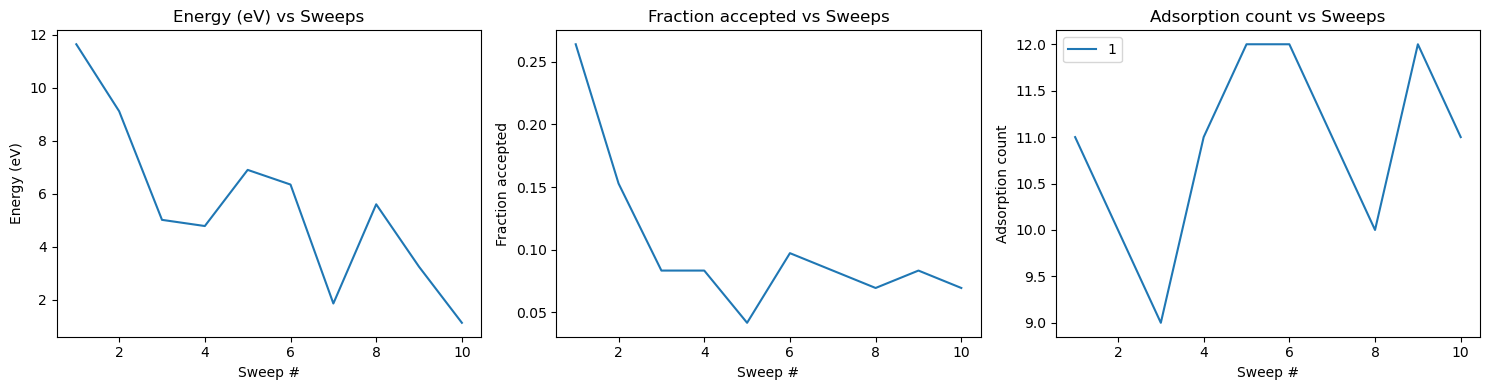

In [5]:
import copy 

run_slab = copy.deepcopy(slab_batch)

mcmc = MCMC(
    calc=nff_calc,
    canonical=False,
    testing=False,
    surface_name=surface_name,
    element=element,
    adsorbates=adsorbates,
    ads_coords=ads_positions,
    relax=relax,
    offset=offset,
    offset_data=offset_data,
    relax_steps=relax_steps,
    optimizer=optimizer
)

start = perf_counter()
# call the main function
mcmc.mcmc_run(num_sweeps=num_sweeps,
    temp=temp,
    pot=chem_pot,
    alpha=alpha,
    slab=run_slab
    )

stop = perf_counter()
print(f"Time taken = {stop - start} seconds")